# 0. Importing Necessary Packages

In [1]:
# Printing the information of Python, IPython, OS, and the generation date.
%load_ext version_information
%version_information

Software versions
Python 2.7.17 64bit [GCC 7.3.0]
IPython 5.8.0
OS Linux 5.8.18 100.fc31.x86_64 x86_64 with fedora 31 Thirty_One
Sat Apr 09 21:38:48 2022 KST

In [2]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'matplotlib', 'pandas', 'astropy', 'pyraf']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.16.5
matplotlib: ver 2.2.3
pandas: ver 0.24.2
astropy: ver 2.0.16
pyraf: ver 2.1.15


In [3]:
# matplotlib backend
%matplotlib notebook

# importing necessary modules
import time
import numpy as np
import glob, os
from matplotlib import pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

current_dir = os.getcwd()
dir_iraf = os.path.abspath('../')    # where 'login.cl' file is located

os.chdir(dir_iraf)
from pyraf import iraf
os.chdir(current_dir)

# 1. Examining Point Sources in the Images

In [5]:
dir_img = "HolmIX/"
imglist = [dir_img+"HolmIX_g.fits", dir_img+"HolmIX_i.fits"]
n_img = len(imglist)
imglist

['HolmIX/HolmIX_g.fits', 'HolmIX/HolmIX_i.fits']

In [6]:
# You can also run this command in terminal.
ds9_options = "-scalemode zscale -scale lock yes -frame lock image "
names = ""
for i in np.arange(n_img):
    names += imglist[i]+" "
ds9_command = "ds9 "+ds9_options+names+"&"
print('Running "'+ds9_command+'" in the terminal...')
os.system(ds9_command)

Running "ds9 -scalemode zscale -scale lock yes -frame lock image HolmIX/HolmIX_g.fits HolmIX/HolmIX_i.fits &" in the terminal...


0

### 1) Running the ``imexamine`` task

#### The ``imexamine`` task ([Reference link](https://iraf.net/irafhelp.php?val=imexamine&help=Help+Page)) is very useful for checking the information of sources in the images!

In [8]:
# Interactively checking the sources
iraf.imexamine()

 10.99  19.03   243.4 0.00279   11.35 0.05   35 4.52     3.75     3.84   3.66
 28.50  19.55   151.1 0.02108  0.6943 0.92  -12 2.02    13.17     9.14   9.57
#            SECTION     NPIX     MEAN   MEDIAN   STDDEV      MIN      MAX
 [228:232,1328:1332]       25   0.5674   0.5769   0.1031   0.3695   0.7487
#   COL    LINE    COORDINATES
#     R    MAG    FLUX     SKY    PEAK    E   PA BETA ENCLOSED   MOFFAT DIRECT
 228.00 1330.48 228.00 1330.48
  28.50  19.53   153.7 0.02026  0.6772 0.89  -13 2.09    13.17     9.36   9.57


#### Please check your mouse cursor blinking in the DS9 window.
#### You can check the selected sources in the images interactively by pressing the following keys.
* ``a`` key: to **select a source** and view its basic information
    * see **``MOFFAT`` to check the FWHM size of the source**)


* ``r`` key: to show **the radial light profile** of the source
* ``e`` key: to show **the contour plot** of the source
* ``s`` key: to show **the surface plot** of the source


* ``q`` key: to quit

In [6]:
# Interactively selecting good point sources in the g-band image
# This task is to estimate the seeing FWHMs of point sources in this image.
# Plus, the selection of point sources will be used as initial PSF stars (next notebook).
logname_g = dir_img+"imexam_g.log"
os.system("rm -rfv "+logname_g)
iraf.imexamine(logfile = logname_g, keeplog = "yes")

In [7]:
poi_g = np.genfromtxt(logname_g, usecols=(0,1,7,9,13), names=('X','Y','SKY','E','MOFFAT'))
med_fwhm_g = np.median(poi_g['MOFFAT'][poi_g['E'] <= 0.15])
print("Using {0:d} sources".format(np.sum(poi_g['E'] <= 0.15)))
print("Median FWHMs of point sources fitted by Moffat profile: {0:.2f} pix (g-band)".format(med_fwhm_g))

Using 16 sources
Median FWHMs of point sources fitted by Moffat profile: 3.84 pix (g-band)


* **Display the ``imexam_g.log`` in the images with the DS9 region.**

    * In DS9, ``Region`` - ``Load Regions`` - Check ``All(*)`` - Set the format (``xy``) and coordinate system (``image``).

In [8]:
# Interactively checking the sources in the i-band image
logname_i = dir_img+"imexam_i.log"
os.system("rm -rfv "+logname_i)
iraf.imexamine(logfile = logname_i, keeplog = "yes")

In [9]:
poi_i = np.genfromtxt(logname_i, usecols=(0,1,7,9,13), names=('X','Y','SKY','E','MOFFAT'))
med_fwhm_i = np.median(poi_i['MOFFAT'][poi_i['E'] <= 0.15])
print("Using {0:d} sources".format(np.sum(poi_i['E'] <= 0.15)))
print("Median FWHMs of point sources fitted by Moffat profile: {0:.2f} pix (i-band)".format(med_fwhm_i))

Using 15 sources
Median FWHMs of point sources fitted by Moffat profile: 3.85 pix (i-band)


In [16]:
np.savetxt(dir_img+"fwhms.txt", [med_fwhm_g, med_fwhm_i], fmt="%.3f")

* **Save the region file (``init_point.reg``) of _good_ point sources**.

    * Set the format (``xy``) and coordiate system (``image``).

# 2. Finding Stars in the Images

In [18]:
img_g, hdr_g = fits.getdata(imglist[0], header=True)
img_i, hdr_i = fits.getdata(imglist[1], header=True)

In [19]:
# Sky, skysigma estimation
sky_value = []
sky_sigma = []
for img in [img_g, img_i]:
    avg, med, std = sigma_clipped_stats(img, sigma=3.0)
    sky_val = 3.0*med - 2.0*avg
    sky_value.append(sky_val)
    sky_sig = std
    sky_sigma.append(sky_sig)
    print(sky_val, sky_sig)

(0.006295278089684497, 0.0336791194964501)
(0.0138313835326756, 0.07592073991204001)


In [23]:
np.savetxt(dir_img+"sky.txt", [sky_value, sky_sigma], delimiter="  ", fmt="%.3e")

In [38]:
iraf.noao()
iraf.digiphot()
iraf.daophot()

In [46]:
# DAOFIND task
band = ["g", "i"]
fwhms = [med_fwhm_g, med_fwhm_i]

start_time = time.time()
for i, img in enumerate([img_g, img_i]):
    coofile = imglist[i].split(".fits")[0]+".coo"
    os.system("rm -rfv "+coofile)
    
    kwargs = {"fwhmpsf":fwhms[i], "sigma":sky_sigma[i], "threshold":4.0, "verify":False}
    iraf.daofind(image=imglist[i], output=coofile, **kwargs)
end_time = time.time()
print("\n--- DAOFIND tasks take {0:.4f} sec ---".format(end_time-start_time))


Image: HolmIX/HolmIX_g.fits  fwhmpsf: 3.845  ratio: 1.  theta: 0.  nsigma: 1.5

  958.97     7.11   -0.004   0.583  -0.044  -0.271     1
  173.53    11.19   -0.747   0.440   0.207  -0.021     2
  573.04    11.08   -0.120   0.235   0.218   0.190     3
 1797.01    10.87   -0.111   0.350  -0.089   0.087     4
  496.87    13.50   -0.317   0.331  -0.204   0.155     5
 1830.98    20.11   -0.609   0.404  -0.150  -0.222     6
 2088.98    19.90   -1.827   0.448   0.185  -0.120     7
 2060.01    21.53   -0.757   0.443   0.176   0.213     8
  757.94    25.96   -0.598   0.648  -0.061  -0.234     9
 1637.89    25.91   -0.449   0.321  -0.516  -0.732    10
 1654.73    26.29   -0.113   0.354   0.104  -0.190    11
 2254.36    31.07   -0.166   0.363   0.406  -0.132    12
  451.56    31.83   -0.112   0.509   0.361   0.415    13
  570.03    31.69   -0.962   0.501   0.212   0.136    14
  661.23    37.57   -0.268   0.438   0.323   0.206    15
  577.83    39.99   -1.178   0.557   0.347   0.079    16
 1062.0

  877.06   232.45   -0.694   0.577   0.570   0.372   144
 2250.92   232.68   -0.698   0.519  -0.083   0.190   145
  616.73   234.83   -0.131   0.708  -0.350  -0.298   146
  832.97   236.13   -0.529   0.398  -0.274   0.275   147
 1096.08   235.23   -0.208   0.492   0.159   0.573   148
 1884.81   237.43   -3.604   0.461   0.257   0.083   149
  542.00   238.05   -0.110   0.395  -0.735  -0.600   150
 1507.95   237.53   -0.323   0.625   0.926  -0.039   151
 2291.92   238.21   -0.089   0.607  -0.003  -0.427   152
  395.80   241.79   -0.414   0.502   0.713   0.197   153
 1891.03   243.18   -0.943   0.471  -0.070   0.141   154
  339.90   245.33   -0.994   0.453   0.282  -0.077   155
 2248.67   248.00   -0.506   0.452  -0.034  -0.349   156
  559.32   249.42   -1.094   0.462   0.359   0.023   157
 1108.62   249.16   -0.147   0.380   0.669  -0.071   158
 1330.42   248.88   -1.321   0.384   0.103  -0.052   159
 1771.85   250.35   -4.121   0.461   0.247   0.090   160
  968.93   250.69   -0.875   0.

 1353.07   446.65   -0.619   0.338  -0.243  -0.448   288
 2197.69   447.32   -1.100   0.442   0.252   0.005   289
 2158.16   448.92   -0.345   0.520  -0.291  -0.136   290
 1036.61   449.58   -0.424   0.315  -0.151   0.042   291
  469.62   450.65   -0.077   0.643  -0.394  -0.309   292
  680.67   456.68   -0.005   0.420   0.257  -0.048   293
  684.60   458.09   -0.039   0.369   0.507   0.519   294
 1538.97   457.72   -0.377   0.472  -0.046   0.149   295
  710.80   458.83   -0.156   0.318  -0.679   0.027   296
 1123.25   459.57   -0.677   0.504   0.340  -0.249   297
 1263.67   461.09   -0.236   0.427  -0.250  -0.284   298
 1183.33   462.63   -0.161   0.531  -0.044   0.063   299
 1333.54   463.58   -0.248   0.354  -0.053  -0.080   300
 1434.09   464.19   -0.073   0.402   0.802  -0.368   301
  746.15   464.30   -0.286   0.341   0.044   0.236   302
 1295.31   466.30   -2.044   0.450   0.254   0.055   303
 1165.49   467.50   -0.177   0.498   0.118   0.149   304
 1351.46   469.45   -1.801   0.

 1543.98   551.30   -1.330   0.474   0.377   0.555   432
 1988.25   549.28   -1.573   0.367   0.144   0.565   433
  597.52   551.22   -0.888   0.327  -0.085  -0.014   434
 1084.99   550.58   -1.631   0.472   0.113   0.106   435
 1397.39   550.64   -0.742   0.524   0.534   0.028   436
 1448.46   551.34   -0.051   0.649  -0.362  -0.417   437
   40.69   552.86   -1.393   0.441   0.168  -0.007   438
 1202.84   552.82   -0.005   0.710  -0.540  -0.434   439
 1542.90   554.80   -1.172   0.794  -0.056  -0.405   440
 1653.82   553.64   -0.006   0.527  -0.034   0.012   441
 1333.95   556.59   -0.022   0.518   0.281   0.049   442
  946.52   557.59   -0.504   0.469   0.290  -0.098   443
 1442.49   558.37   -0.325   0.495   0.030   0.490   444
 2121.73   557.91   -1.578   0.477   0.348   0.048   445
 1610.01   559.60   -0.646   0.448   0.165   0.500   446
 1692.19   559.22   -0.693   0.415  -0.090  -0.048   447
 1726.56   558.63   -0.204   0.482   0.357   0.296   448
  793.24   560.68   -0.896   0.

 2127.63   618.52   -0.321   0.449   0.156  -0.192   576
  988.78   620.06   -0.342   0.477  -0.261  -0.240   577
 2274.33   620.07   -0.342   0.437  -0.205  -0.231   578
  657.15   620.99   -0.298   0.349  -0.139   0.346   579
 1432.45   621.11   -1.383   0.491   0.260   0.101   580
  502.66   621.83   -0.391   0.506   0.593   0.268   581
  751.76   622.28   -0.132   0.471   0.150  -0.062   582
  831.68   622.88   -0.302   0.339   0.394   0.020   583
 1210.69   621.82   -1.404   0.470   0.071  -0.063   584
 1882.81   622.50   -0.551   0.363  -0.514  -0.173   585
 1989.57   622.49   -3.918   0.223   0.384  -0.597   586
 1236.89   622.69   -0.258   0.369   0.279   0.315   587
 1538.50   623.08   -0.202   0.646   0.692   0.324   588
 1542.34   623.09   -0.649   0.300   0.105  -0.376   589
 1980.20   622.53   -4.480   0.576  -0.886  -0.454   590
  508.62   624.46   -0.105   0.507  -0.270  -0.287   591
  793.11   623.62   -0.204   0.435   0.718   0.480   592
 2044.18   624.26   -3.628   0.

   47.17   659.67   -1.140   0.434   0.316   0.246   720
 1735.93   660.54   -0.504   0.622   0.028   0.188   721
 2010.44   658.84   -0.188   0.367  -0.254   0.094   722
 2178.62   659.83   -1.559   0.484   0.395   0.651   723
 1476.38   661.54   -0.759   0.403  -0.154  -0.516   724
 1629.09   660.43   -0.155   0.457   0.040   0.065   725
 1711.47   660.78   -0.880   0.387   0.092   0.013   726
 2024.09   660.84   -0.082   0.455  -0.401  -0.332   727
 1192.93   661.84   -0.764   0.465   0.452  -0.029   728
  790.52   662.94   -1.455   0.457   0.287   0.078   729
 1684.32   663.74   -0.248   0.330  -0.015   0.094   730
 1754.59   663.51   -0.707   0.424  -0.224  -0.196   731
 1964.97   663.39   -4.609   0.441   0.219   0.059   732
 2042.15   662.94   -0.351   0.515   0.397  -0.082   733
 2150.21   662.66   -1.684   0.491   0.242   0.152   734
 1226.11   664.02   -0.527   0.505  -0.091  -0.235   735
 2202.58   664.54   -0.082   0.423   0.031  -0.280   736
 1005.85   664.97   -0.725   0.

 2226.50   696.36   -2.913   0.432   0.088   0.018   864
 1615.30   696.78   -0.864   0.535   0.201  -0.840   865
 1620.49   696.65   -3.281   0.451   0.249  -0.014   866
 2050.65   697.22   -1.476   0.473   0.187   0.205   867
  942.89   698.35   -0.295   0.533   0.273   0.087   868
 2023.46   697.84   -0.996   0.506   0.152  -0.245   869
 1297.91   699.25   -0.508   0.399   0.643   0.184   870
 1933.49   700.92   -0.924   0.357   0.059   0.471   871
 2151.58   699.24   -0.270   0.310  -0.182  -0.595   872
  635.96   699.30   -0.546   0.422  -0.814  -0.277   873
  846.77   699.43   -0.295   0.456   0.375   0.008   874
 1074.33   699.70   -0.307   0.643  -0.258  -0.047   875
  879.29   701.25   -1.363   0.422   0.212   0.115   876
 1268.88   701.13   -0.543   0.536   0.455   0.254   877
 1956.54   701.90   -0.556   0.599   0.448   0.221   878
 1969.06   700.94   -1.248   0.437   0.315  -0.059   879
 1974.72   701.15   -1.320   0.471   0.444   0.213   880
 2066.63   701.18   -0.989   0.

 1687.38   731.04   -0.546   0.448   0.325  -0.008  1008
 1758.06   730.99   -1.945   0.457   0.339   0.116  1009
 1920.75   731.17   -3.421   0.451   0.179   0.079  1010
 2002.08   730.50   -3.097   0.441   0.265   0.091  1011
  827.22   731.17   -0.083   0.402   0.459   0.400  1012
 1882.47   732.37   -0.104   0.394   0.611   0.305  1013
 2018.11   731.94   -0.667   0.407  -0.224   0.031  1014
 2201.03   732.58   -0.077   0.520   0.221  -0.121  1015
   42.47   733.41   -0.262   0.286  -0.196   0.108  1016
 1862.87   732.76   -0.747   0.558   0.107   0.242  1017
 1872.02   733.38   -0.333   0.422   0.176  -0.048  1018
 2399.98   733.76   -0.385   0.525   0.962  -0.080  1019
  121.06   734.18   -1.808   0.468   0.252   0.042  1020
 1573.04   734.19   -1.672   0.423   0.021  -0.145  1021
 2134.36   734.42   -0.661   0.413  -0.065  -0.127  1022
 1226.10   734.49   -1.659   0.421   0.091  -0.016  1023
 1385.32   734.63   -0.293   0.456   0.138  -0.128  1024
 1404.82   734.95   -0.002   0.

 1302.94   760.77   -0.283   0.533   0.150   0.033  1152
 1328.77   761.24   -1.152   0.407   0.121   0.202  1153
 1440.93   760.95   -0.373   0.468  -0.086   0.359  1154
 1557.05   760.40   -0.248   0.431  -0.067  -0.387  1155
 1565.92   760.50   -3.667   0.439   0.320   0.002  1156
 1885.57   760.50   -2.469   0.437   0.363   0.048  1157
 1996.99   761.20   -1.149   0.455   0.289  -0.069  1158
 2123.53   761.02   -2.056   0.445   0.119  -0.043  1159
 1381.06   761.38   -0.826   0.416  -0.019  -0.003  1160
 2166.60   762.16   -2.253   0.443   0.118  -0.011  1161
 1073.35   762.24   -0.194   0.575   0.396   0.727  1162
 1240.74   762.75   -3.081   0.457   0.219   0.024  1163
 1477.47   762.59   -5.595   0.454   0.282  -0.004  1164
 1536.83   762.49   -0.068   0.583   0.029  -0.224  1165
 2026.40   763.01   -0.593   0.458  -0.317  -0.223  1166
 1218.62   763.98   -0.968   0.395   0.160   0.101  1167
 1594.26   763.38   -0.526   0.413   0.323   0.261  1168
 1823.69   764.63   -0.014   0.

 1636.27   790.17   -2.923   0.457   0.189  -0.027  1296
 1756.92   790.03   -2.665   0.449   0.251   0.079  1297
 1900.23   789.57   -0.600   0.464  -0.539  -0.438  1298
 2015.59   789.33   -0.349   0.509   0.094  -0.198  1299
  656.11   791.29   -2.362   0.467   0.201   0.058  1300
 1462.09   790.94   -0.267   0.412   0.258  -0.149  1301
 1486.68   790.43   -2.327   0.449   0.209   0.024  1302
 1510.24   792.14   -0.454   0.509   0.418   0.479  1303
 1544.73   790.93   -0.655   0.522   0.202  -0.220  1304
 1880.84   791.35   -1.359   0.445   0.200   0.072  1305
  425.24   792.07   -0.048   0.402   0.597   0.718  1306
 1304.22   791.87   -0.257   0.481   0.217  -0.596  1307
 1439.77   792.17   -0.060   0.454   0.037  -0.060  1308
 1579.90   793.07   -0.394   0.399   0.357   0.192  1309
 2255.96   791.14   -0.543   0.409   0.467   0.447  1310
 1178.75   792.80   -2.929   0.459   0.213   0.071  1311
 1308.44   793.38   -0.609   0.550   0.260  -0.113  1312
 1946.94   793.40   -0.082   0.

 1524.88   815.62   -0.037   0.501  -0.170  -0.508  1440
 1594.48   815.17   -0.737   0.468   0.421   0.279  1441
 1647.10   815.12   -0.565   0.456   0.055  -0.270  1442
 1723.62   815.26   -0.956   0.424   0.003  -0.098  1443
 1753.87   814.85   -0.712   0.466   0.672   0.144  1444
 1786.56   813.71   -0.059   0.455   0.058  -0.030  1445
 1922.50   814.84   -2.540   0.449   0.167  -0.064  1446
  886.83   815.87   -0.915   0.507   0.400   0.168  1447
  942.69   816.52   -0.218   0.486  -0.043   0.114  1448
 1296.30   816.55   -0.184   0.600  -0.105   0.332  1449
 1566.68   815.91   -1.946   0.463   0.393   0.280  1450
 1622.57   816.83   -0.308   0.444  -0.200   0.673  1451
 1884.77   816.09   -0.360   0.627   0.150  -0.020  1452
 2304.26   815.73   -2.751   0.417  -0.051  -0.483  1453
 1286.66   816.94   -1.296   0.503   0.244   0.091  1454
 1303.30   816.17   -0.046   0.515  -0.389   0.289  1455
 1532.18   817.21   -1.275   0.451   0.118  -0.057  1456
 1666.41   817.54   -1.144   0.

 1473.41   837.05   -1.205   0.558  -0.072   0.388  1584
 1902.89   837.34   -0.269   0.646  -0.048  -0.407  1585
  748.90   837.69   -0.402   0.494   0.612   0.482  1586
 1078.99   837.90   -0.638   0.525   0.181  -0.165  1587
 1337.89   838.37   -0.965   0.471   0.191  -0.373  1588
 1351.92   838.11   -1.039   0.521  -0.276  -0.736  1589
 2009.52   838.16   -3.105   0.448   0.229  -0.062  1590
 2181.15   838.05   -0.469   0.443  -0.190  -0.189  1591
 1263.37   838.57   -1.030   0.403   0.261   0.087  1592
 1509.33   839.53   -2.647   0.466   0.361   0.127  1593
 1638.64   838.90   -0.732   0.384   0.775   0.101  1594
 1653.83   838.01   -0.337   0.391   0.545   0.233  1595
 1984.67   839.14   -0.004   0.554  -0.344  -0.004  1596
 2217.36   839.84   -0.204   0.492   0.425   0.250  1597
  877.04   840.32   -0.573   0.554   0.458   0.223  1598
 1308.29   840.29   -0.570   0.476   0.421   0.172  1599
 1996.15   840.36   -0.454   0.495   0.168   0.311  1600
 2014.80   840.04   -2.700   0.

 1523.99   861.23   -0.559   0.469   0.510   0.647  1728
 1790.64   861.70   -0.022   0.508   0.267   0.188  1729
 1954.05   861.73   -0.280   0.365   0.272  -0.013  1730
 1115.72   862.49   -0.106   0.575   0.123  -0.209  1731
 1441.14   863.33   -0.002   0.369   0.270   0.240  1732
 1836.87   863.19   -0.169   0.364   0.049  -0.167  1733
 1885.76   862.64   -2.573   0.446   0.351   0.095  1734
 1299.48   864.47   -0.543   0.465   0.099  -0.071  1735
 1414.74   863.96   -1.104   0.448   0.114   0.036  1736
 1666.68   863.93   -2.786   0.448   0.148  -0.015  1737
 1874.97   864.24   -0.552   0.449   0.414   0.122  1738
 2023.36   863.47   -1.097   0.517   0.041  -0.048  1739
  786.89   864.22   -0.519   0.447   0.228   0.488  1740
 1246.60   864.89   -0.511   0.421   0.014  -0.073  1741
 1355.51   865.48   -3.309   0.436   0.190  -0.182  1742
 1845.66   864.96   -0.077   0.431   0.837  -0.082  1743
 1893.22   865.16   -2.246   0.442   0.310   0.019  1744
 1378.00   864.80   -0.152   0.

 1441.73   886.76   -0.296   0.400   0.638   0.329  1872
 1547.82   887.37   -2.141   0.461   0.071   0.058  1873
 1778.33   886.75   -1.979   0.449   0.168   0.038  1874
 1843.23   887.46   -0.184   0.496   0.019  -0.348  1875
 1850.86   886.72   -2.146   0.446   0.248   0.034  1876
   27.19   887.99   -0.606   0.380   0.688   0.101  1877
  880.01   888.44   -1.713   0.435   0.146   0.027  1878
 1233.80   887.33   -0.351   0.804   0.480   0.120  1879
 1376.18   887.87   -1.377   0.431   0.480  -0.356  1880
 1607.13   888.08   -1.550   0.384  -0.290   0.004  1881
 1740.35   887.99   -0.319   0.357  -0.114  -0.715  1882
 1807.45   887.79   -0.059   0.422  -0.043   0.633  1883
 2042.65   887.59   -3.067   0.456   0.357   0.034  1884
  935.61   888.57   -1.298   0.484  -0.215  -0.102  1885
 1037.04   888.68   -0.779   0.487   0.113   0.030  1886
 1501.37   889.24   -0.062   0.373   0.415   0.120  1887
 1673.07   889.35   -2.504   0.462   0.323  -0.048  1888
 1714.17   889.84   -0.229   0.

 1396.91   911.01   -1.620   0.449   0.015  -0.024  2016
 1696.73   911.65   -0.116   0.446  -0.154   0.235  2017
 2003.92   911.76   -2.927   0.443   0.317   0.359  2018
 2034.31   910.87   -1.892   0.474   0.334   0.091  2019
  474.60   912.06   -0.132   0.506   0.408   0.244  2020
 1458.23   912.13   -0.124   0.427   0.684   0.695  2021
 1554.74   912.56   -0.210   0.542   0.464   0.322  2022
 1568.36   911.75   -1.071   0.433   0.300   0.068  2023
 1714.11   911.89   -0.577   0.523   0.456   0.020  2024
 1912.83   912.40   -0.581   0.512   0.529   0.075  2025
 2438.07   911.97   -1.454   0.371   0.231  -0.033  2026
  968.52   912.88   -0.147   0.450   0.077   0.052  2027
 1291.16   912.34   -0.204   0.486   0.422  -0.009  2028
 1311.51   913.14   -0.311   0.366  -0.141  -0.219  2029
 1368.92   913.41   -1.226   0.433   0.199   0.038  2030
 1531.27   912.29   -0.421   0.461   0.390   0.043  2031
 1704.89   912.84   -2.083   0.455   0.269   0.032  2032
 1810.23   912.81   -0.178   0.

 1408.33   933.58   -2.673   0.442   0.111   0.000  2160
 1818.45   934.67   -0.386   0.466   0.079   0.423  2161
 1848.76   933.67   -1.537   0.463   0.232  -0.119  2162
  845.37   934.51   -0.122   0.446   0.120   0.083  2163
 1083.27   934.81   -1.266   0.431   0.213   0.140  2164
 1503.98   934.63   -2.578   0.443   0.332   0.049  2165
 1730.58   935.88   -0.992   0.528   0.050   0.231  2166
 1779.37   935.61   -0.551   0.586   0.578   0.137  2167
 1864.76   934.47   -0.227   0.544   0.570   0.056  2168
 2098.47   934.76   -0.320   0.477   0.248   0.385  2169
 1446.38   936.28   -0.495   0.348   0.791   0.235  2170
 1499.09   936.26   -1.631   0.485   0.011  -0.441  2171
 1545.43   935.93   -0.580   0.518  -0.434  -0.458  2172
 1556.65   935.81   -1.473   0.441  -0.074  -0.030  2173
 1603.66   936.19   -0.418   0.495  -0.508  -0.252  2174
 1694.11   936.04   -1.539   0.444   0.161   0.112  2175
 1760.13   935.44   -0.665   0.506   0.546   0.160  2176
   22.10   937.46   -0.110   0.

 1102.28   955.16   -1.486   0.508   0.565   0.214  2304
 1191.65   955.06   -0.491   0.547   0.234  -0.023  2305
 1333.54   954.93   -0.241   0.458   0.135  -0.091  2306
 1356.80   954.79   -0.602   0.458   0.338  -0.123  2307
 1410.52   954.75   -2.395   0.439   0.263   0.075  2308
 1474.04   955.17   -2.490   0.462   0.181   0.097  2309
 1516.10   954.48   -2.031   0.461  -0.158  -0.178  2310
 1611.15   955.74   -1.125   0.467   0.211  -0.358  2311
 1679.48   954.86   -0.435   0.331   0.131   0.235  2312
 1800.48   954.59   -0.002   0.569   0.395  -0.013  2313
  811.21   956.20   -0.420   0.447  -0.567  -0.155  2314
 1118.61   956.69   -1.072   0.453   0.334   0.255  2315
 1246.82   956.06   -1.999   0.456   0.047   0.028  2316
 1375.73   955.78   -0.726   0.595   0.112  -0.111  2317
 1399.94   956.60   -0.434   0.454   0.187   0.439  2318
 1501.92   956.45   -1.198   0.472  -0.068  -0.027  2319
 1513.32   955.20   -1.386   0.499   0.181  -0.291  2320
 1578.10   955.68   -2.031   0.

  801.67   976.81   -0.244   0.414  -0.068  -0.440  2448
 1188.82   976.91   -0.155   0.574   0.300  -0.030  2449
 1265.51   977.28   -0.098   0.388   0.413   0.160  2450
 1804.13   977.16   -2.327   0.462   0.150   0.050  2451
 1885.50   976.64   -2.014   0.429   0.323   0.038  2452
 2399.53   977.20   -1.317   0.441  -0.120  -0.247  2453
 1114.18   978.33   -0.079   0.425   0.432   0.330  2454
 1335.56   977.71   -0.750   0.397   0.338   0.174  2455
 1436.17   978.49   -2.804   0.450   0.217   0.125  2456
 1456.39   978.73   -0.634   0.520   0.603   0.301  2457
 1545.72   976.96   -1.114   0.406   0.456   0.150  2458
  993.94   978.98   -0.872   0.402  -0.350  -0.437  2459
 1216.26   978.56   -1.314   0.430  -0.122  -0.007  2460
 1442.18   978.42   -0.795   0.419   0.567  -0.331  2461
 1469.58   979.12   -1.890   0.429  -0.170   0.028  2462
 1564.65   978.62   -1.432   0.471  -0.076   0.176  2463
 1571.10   978.45   -0.580   0.405   0.419   0.418  2464
 1680.39   978.89   -0.842   0.

  669.62  1000.02   -0.079   0.655   0.310  -0.031  2592
 1334.19  1001.29   -1.470   0.405   0.764   0.320  2593
 1568.05   999.70   -0.565   0.442   0.020  -0.125  2594
 1609.55   999.47   -0.715   0.386   0.106  -0.531  2595
 1655.92  1000.10   -0.788   0.472   0.573  -0.900  2596
 1421.08  1000.72   -2.608   0.450   0.143   0.054  2597
 1453.63  1002.18   -1.261   0.421   0.603   0.438  2598
 1597.60  1000.64   -3.789   0.454   0.237  -0.009  2599
 1666.96  1000.81   -0.563   0.402  -0.065  -0.340  2600
 1678.73  1000.26   -0.171   0.472   0.582   0.364  2601
  934.51  1002.43   -0.635   0.383   0.292   0.176  2602
 1196.61  1001.81   -0.075   0.570  -0.212  -0.084  2603
 1225.15  1001.44   -0.447   0.463  -0.083   0.415  2604
 1270.37  1001.49   -0.373   0.528   0.508   0.224  2605
 1481.04  1001.45   -0.390   0.419   0.392  -0.300  2606
 1840.38  1002.21   -0.728   0.456   0.125  -0.154  2607
 1991.41  1002.14   -1.523   0.462   0.223   0.090  2608
  861.01  1002.85   -0.803   0.

  520.03  1018.67   -1.316   0.501   0.247   0.075  2736
 1146.04  1018.97   -0.867   0.411   0.171  -0.140  2737
 1417.00  1018.26   -1.308   0.495   0.854  -0.349  2738
 1426.45  1019.26   -2.498   0.439   0.194  -0.015  2739
 1506.00  1018.95   -2.112   0.488   0.667  -0.258  2740
 1537.51  1019.05   -2.742   0.439   0.117  -0.022  2741
 1651.55  1019.26   -2.221   0.462   0.261   0.079  2742
  881.84  1019.66   -0.641   0.465   0.506   0.186  2743
  913.28  1019.20   -0.547   0.431  -0.280   0.054  2744
 1069.96  1021.38   -1.088   0.377   0.780   0.843  2745
 1328.33  1020.14   -1.756   0.502  -0.009  -0.140  2746
 1368.44  1020.33   -0.323   0.380   0.126   0.156  2747
 1393.82  1020.19   -0.905   0.337  -0.149   0.521  2748
 1401.47  1020.31   -1.683   0.427  -0.229   0.312  2749
 1463.80  1019.15   -0.857   0.431   0.821   0.078  2750
 1521.93  1020.61   -1.296   0.478   0.203   0.251  2751
 1455.10  1020.73   -0.955   0.423   0.743   0.523  2752
 1489.69  1020.89   -0.445   0.

 1396.90  1041.98   -0.236   0.342   0.321   0.889  2880
 1491.77  1040.64   -1.224   0.416  -0.254  -0.301  2881
 1692.27  1040.99   -0.130   0.442   0.737  -0.450  2882
 1767.41  1041.02   -1.306   0.467   0.422   0.106  2883
 1851.66  1041.11   -0.671   0.388   0.288  -0.121  2884
  672.50  1042.31   -1.122   0.445   0.128  -0.094  2885
 1230.21  1041.70   -0.605   0.566   0.323  -0.316  2886
 1434.42  1041.80   -1.610   0.432   0.395   0.174  2887
 1664.28  1042.25   -1.719   0.445   0.243   0.058  2888
 1678.10  1042.53   -0.481   0.412   0.461  -0.585  2889
 2314.23  1041.12   -0.555   0.478   0.170   0.259  2890
  936.60  1042.55   -1.060   0.539   0.438  -0.034  2891
 1180.86  1043.18   -0.412   0.520   0.218   0.459  2892
 1371.51  1043.48   -1.367   0.448   0.095   0.367  2893
 1507.55  1043.89   -1.596   0.423  -0.012   0.268  2894
 1606.55  1042.86   -1.735   0.432   0.099  -0.111  2895
 1634.58  1042.99   -0.881   0.450   0.530  -0.102  2896
 1717.89  1043.10   -0.604   0.

 1634.09  1061.32   -0.860   0.440  -0.132  -0.207  3024
 1646.20  1060.80   -0.575   0.456   0.227   0.142  3025
 1727.95  1060.72   -2.603   0.421   0.181  -0.754  3026
 1039.22  1062.60   -0.376   0.438   0.454   0.032  3027
 1056.43  1061.74   -0.046   0.621   0.299   0.039  3028
 1324.77  1061.62   -1.206   0.522  -0.001  -0.093  3029
 1354.52  1062.31   -1.004   0.458   0.324  -0.255  3030
 1378.95  1062.10   -1.161   0.502   0.190   0.154  3031
 1707.04  1061.79   -1.236   0.395  -0.032  -0.134  3032
 1771.17  1062.12   -0.298   0.608   0.203   0.016  3033
 1984.35  1062.56   -0.449   0.603  -0.734  -0.302  3034
  654.76  1063.18   -0.956   0.484  -0.008  -0.456  3035
  712.22  1062.95   -0.552   0.381   0.329  -0.150  3036
 1003.69  1063.05   -1.358   0.472   0.240  -0.067  3037
 1289.00  1063.34   -2.390   0.431   0.329   0.098  3038
 1345.72  1062.52   -0.029   0.475   0.181   0.408  3039
 1401.29  1062.73   -0.067   0.341   0.739   0.175  3040
 1608.35  1063.01   -0.741   0.

 1673.29  1085.17   -0.434   0.518   0.724   0.776  3168
 1729.04  1083.83   -2.258   0.439   0.299   0.202  3169
 1915.58  1083.05   -0.297   0.357   0.447   0.223  3170
  790.89  1084.71   -0.580   0.432   0.249   0.100  3171
 1089.87  1084.90   -0.043   0.392  -0.540   0.574  3172
 1140.51  1085.18   -0.297   0.401   0.318  -0.394  3173
 1336.65  1084.86   -1.501   0.408  -0.164  -0.417  3174
 1477.61  1085.51   -0.820   0.565   0.113   0.089  3175
 1804.91  1085.16   -0.128   0.538   0.465  -0.215  3176
 1949.19  1084.72   -0.491   0.528   0.076   0.016  3177
 1007.51  1085.87   -1.869   0.452   0.170  -0.032  3178
 1185.05  1086.62   -0.542   0.427   0.242  -0.196  3179
 1415.76  1085.99   -0.532   0.489  -0.032   0.081  3180
 1577.58  1085.77   -1.049   0.426   0.201   0.111  3181
 1690.20  1085.86   -0.201   0.446   0.606  -0.449  3182
 1811.59  1085.98   -0.159   0.383   0.304  -0.659  3183
 1189.23  1087.46   -0.978   0.444   0.412  -0.067  3184
 1421.22  1086.69   -0.409   0.

 1415.73  1106.73   -0.077   0.564   0.178   0.516  3312
 1484.96  1104.64   -1.161   0.473   0.397   0.230  3313
 1601.68  1104.87   -0.598   0.437   0.420  -0.112  3314
 1641.20  1105.35   -2.528   0.442   0.163   0.003  3315
 1762.29  1105.10   -0.727   0.453  -0.794  -0.343  3316
   58.26  1106.19   -0.486   0.483  -0.289  -0.141  3317
  861.15  1106.35   -2.415   0.450   0.172   0.048  3318
 1188.85  1106.05   -1.934   0.446  -0.056   0.127  3319
 1212.61  1105.34   -0.366   0.454   0.534   0.310  3320
 1328.14  1104.94   -0.773   0.316   0.278  -0.014  3321
 1379.66  1105.79   -2.468   0.472   0.314   0.087  3322
 1563.17  1105.33   -1.058   0.482   0.419   0.446  3323
 1624.78  1105.73   -0.645   0.518   0.925   0.300  3324
 1710.68  1106.06   -0.767   0.501   0.262   0.205  3325
 1726.82  1105.65   -0.132   0.600  -0.212  -0.120  3326
 1060.75  1106.87   -0.887   0.411   0.123  -0.255  3327
 1171.25  1107.36   -0.902   0.483  -0.069  -0.132  3328
 1477.81  1107.21   -1.083   0.

 1169.64  1126.34   -2.953   0.460   0.109   0.080  3456
 1374.82  1126.59   -1.446   0.460   0.206   0.180  3457
 1543.29  1125.89   -0.765   0.392  -0.617  -0.119  3458
 1783.54  1126.01   -1.400   0.456  -0.031  -0.012  3459
 1415.12  1126.69   -0.438   0.510  -0.351   0.253  3460
 1430.65  1126.75   -0.148   0.649  -0.008   0.442  3461
 1554.57  1126.71   -0.494   0.359   0.626   0.123  3462
 1565.68  1126.20   -1.700   0.435   0.127   0.008  3463
 1588.84  1127.07   -0.489   0.479  -0.060  -0.886  3464
 1676.72  1126.87   -1.126   0.528   0.494   0.222  3465
 1729.52  1126.78   -1.971   0.456   0.159  -0.013  3466
 1950.42  1127.15   -2.157   0.447   0.333  -0.021  3467
 1083.16  1128.07   -1.425   0.457   0.081  -0.032  3468
 1518.85  1127.89   -0.068   0.538   0.605   0.563  3469
 1656.33  1128.01   -0.168   0.341   0.907   0.371  3470
 1663.86  1127.14   -0.032   0.426  -0.464   0.426  3471
 1691.26  1129.10   -1.160   0.403   0.053  -0.239  3472
 1737.71  1127.60   -2.582   0.

 1117.39  1150.01   -2.095   0.457   0.142  -0.020  3600
 1519.93  1150.21   -2.004   0.465   0.285   0.138  3601
 1551.20  1149.42   -0.650   0.423   0.452   0.707  3602
 1558.00  1149.12   -0.710   0.493   0.140   0.030  3603
 1651.19  1150.77   -0.362   0.426   0.927   0.276  3604
 2051.69  1149.58   -0.127   0.466  -0.304  -0.252  3605
  671.47  1151.19   -0.782   0.479  -0.224  -0.415  3606
 1284.64  1151.07   -0.316   0.483   0.577  -0.193  3607
 1440.34  1150.98   -0.041   0.241   0.349  -0.352  3608
 1483.25  1151.20   -4.241   0.454   0.266   0.039  3609
 1588.21  1150.67   -2.359   0.418  -0.099  -0.153  3610
 1747.45  1150.96   -3.323   0.463   0.243  -0.077  3611
 1970.91  1150.74   -0.111   0.410  -0.531   0.059  3612
  941.21  1151.89   -0.448   0.348  -0.341  -0.009  3613
 1416.06  1152.87   -0.531   0.455   0.051   0.360  3614
 1462.21  1151.88   -0.459   0.533   0.482  -0.734  3615
 1821.56  1152.94   -1.337   0.517   0.223   0.205  3616
  483.38  1153.59   -0.160   0.

 1559.96  1178.46   -3.232   0.447   0.275   0.069  3744
 1571.74  1177.48   -1.776   0.462   0.224   0.148  3745
 1665.43  1178.10   -0.460   0.487   0.649  -0.842  3746
 1722.70  1177.77   -2.697   0.445   0.206   0.016  3747
 1184.86  1179.07   -1.400   0.471  -0.121  -0.350  3748
 1511.02  1178.85   -3.148   0.462   0.177   0.024  3749
 1620.60  1179.23   -0.054   0.445   0.403  -0.591  3750
 1649.37  1178.47   -0.618   0.389   0.114  -0.436  3751
 1701.74  1179.27   -0.776   0.463   0.242  -0.539  3752
  680.83  1179.59   -0.596   0.396   0.571   0.026  3753
 1151.13  1181.14   -0.022   0.470   0.498   0.525  3754
 1608.61  1179.73   -2.811   0.441   0.350  -0.068  3755
 1215.46  1181.09   -0.664   0.436   0.211  -0.203  3756
 1388.23  1181.04   -0.853   0.410   0.401  -0.127  3757
  704.91  1181.46   -0.216   0.396  -0.022   0.201  3758
 1001.48  1182.05   -1.133   0.475   0.087   0.015  3759
 1042.10  1181.84   -0.945   0.508   0.208   0.226  3760
 1179.06  1181.38   -0.374   0.

 1703.48  1205.68   -2.128   0.456   0.311   0.047  3888
 1766.44  1205.77   -0.711   0.583  -0.141   0.148  3889
 1274.85  1206.51   -0.880   0.421  -0.015   0.041  3890
 1482.62  1206.85   -1.883   0.422   0.073  -0.038  3891
 1498.37  1206.69   -1.990   0.453   0.057  -0.081  3892
 1506.43  1206.28   -0.099   0.456  -0.009  -0.232  3893
 1332.31  1207.50   -1.603   0.397   0.088   0.079  3894
 1411.32  1207.16   -2.292   0.452   0.154   0.147  3895
 1442.01  1207.74   -0.367   0.406   0.142   0.422  3896
 1488.77  1207.63   -2.181   0.473   0.198   0.011  3897
 1603.24  1207.16   -0.583   0.414   0.051   0.554  3898
 1617.09  1207.64   -1.693   0.467   0.084  -0.049  3899
 1643.89  1207.68   -0.513   0.445  -0.576  -0.006  3900
 1045.17  1209.12   -0.453   0.539   0.279  -0.005  3901
 1387.64  1208.91   -2.531   0.443   0.621   0.017  3902
 1528.07  1208.51   -0.689   0.430   0.024   0.068  3903
  809.20  1209.99   -0.892   0.459   0.325  -0.114  3904
 1007.18  1209.23   -0.548   0.

 1253.19  1242.19   -0.617   0.358  -0.492   0.038  4032
 1549.53  1241.99   -1.005   0.485   0.463  -0.026  4033
 1623.71  1241.80   -0.319   0.454  -0.927  -0.985  4034
  443.45  1242.89   -0.110   0.380   0.072  -0.157  4035
  702.56  1243.00   -0.052   0.579  -0.060  -0.038  4036
  986.53  1242.92   -0.285   0.461   0.371   0.017  4037
 1631.93  1243.05   -1.133   0.311   0.017   0.380  4038
  417.30  1243.60   -0.622   0.430   0.109  -0.349  4039
 1215.07  1244.11   -0.109   0.271   0.707  -0.112  4040
  451.27  1244.77   -0.490   0.541   0.077   0.039  4041
 1237.88  1245.00   -0.536   0.402   0.650   0.313  4042
 1394.84  1245.02   -1.049   0.567  -0.001  -0.389  4043
 1426.24  1244.65   -0.171   0.507   0.244   0.258  4044
 1600.00  1247.00   -0.006   0.440   0.929   0.945  4045
 1177.12  1245.79   -1.256   0.473  -0.039   0.153  4046
 1374.27  1245.94   -0.108   0.560   0.199   0.084  4047
 1398.60  1245.67   -0.649   0.664   0.574  -0.028  4048
 1415.71  1246.25   -0.965   0.

  668.11  1281.14   -0.542   0.376   0.265   0.007  4176
 1156.33  1281.64   -0.053   0.495   0.250   0.089  4177
 1199.97  1282.53   -2.259   0.464   0.356   0.111  4178
  887.19  1285.48   -1.539   0.457   0.382   0.145  4179
 1226.35  1285.39   -0.464   0.414  -0.010  -0.475  4180
 1289.67  1285.49   -0.170   0.369   0.443  -0.295  4181
 1370.00  1284.40   -0.364   0.425   0.086   0.149  4182
 1509.96  1284.23   -0.927   0.481  -0.019   0.177  4183
 1549.32  1284.96   -0.213   0.486  -0.191  -0.307  4184
 1570.04  1284.52   -0.524   0.526   0.209   0.105  4185
 1585.54  1285.01   -0.338   0.465  -0.216  -0.049  4186
 1597.03  1285.05   -0.658   0.427   0.011   0.339  4187
 1173.71  1286.07   -0.240   0.494   0.854   0.165  4188
 1293.19  1286.30   -0.236   0.445   0.356   0.305  4189
  862.54  1286.58   -3.839   0.457   0.316   0.032  4190
 1361.17  1286.71   -2.401   0.432   0.202   0.034  4191
 1615.27  1287.30   -0.513   0.317   0.302   0.407  4192
 1744.42  1287.43   -0.849   0.

 2329.60  1332.94   -0.303   0.540  -0.156   0.327  4320
  905.20  1333.13   -1.850   0.463  -0.228  -0.215  4321
 1604.73  1332.66   -0.544   0.451  -0.192  -0.269  4322
  620.82  1334.59   -0.558   0.530   0.435   0.595  4323
 1265.22  1333.49   -1.146   0.430   0.212   0.259  4324
 1294.63  1334.15   -0.457   0.444   0.327   0.360  4325
 1231.27  1334.68   -1.535   0.426  -0.021  -0.367  4326
 1755.89  1334.95   -0.633   0.419  -0.172   0.153  4327
 1909.65  1336.03   -0.008   0.578  -0.301  -0.258  4328
  610.59  1337.17   -0.418   0.348   0.654   0.198  4329
 1333.07  1337.18   -2.286   0.457   0.277   0.098  4330
 1277.05  1338.38   -1.126   0.453   0.121   0.021  4331
 1355.82  1337.86   -0.341   0.499   0.730   0.314  4332
 2283.91  1338.05   -0.045   0.509   0.439  -0.199  4333
 1186.53  1339.36   -2.286   0.440   0.066   0.042  4334
 1569.85  1338.92   -0.202   0.366   0.156  -0.152  4335
 1268.67  1339.88   -1.685   0.448  -0.042   0.099  4336
 1476.73  1339.86   -1.712   0.

 1270.16  1393.28   -0.778   0.536   0.098   0.284  4464
 1527.65  1393.87   -0.616   0.496  -0.113   0.106  4465
 1657.62  1394.65   -0.268   0.499  -0.073   0.088  4466
  761.06  1394.55   -0.567   0.565  -0.042   0.199  4467
 1395.31  1394.39   -0.466   0.534  -0.317   0.199  4468
 1641.22  1395.33   -1.153   0.519   0.327  -0.068  4469
 1287.62  1395.74   -1.947   0.472   0.327   0.161  4470
 1300.58  1395.80   -0.099   0.628   0.191  -0.092  4471
 1380.22  1396.38   -1.393   0.465   0.341   0.071  4472
 1823.22  1396.20   -0.690   0.367   0.444  -0.053  4473
 1145.04  1396.52   -1.610   0.440   0.014  -0.060  4474
 1850.46  1397.09   -1.584   0.451   0.155  -0.031  4475
 1262.43  1398.22   -1.053   0.490   0.243   0.005  4476
 1430.35  1397.85   -0.708   0.480   0.329   0.083  4477
 1455.15  1398.45   -0.520   0.444  -0.127  -0.142  4478
 1552.47  1399.41   -1.071   0.434  -0.027  -0.139  4479
  810.77  1401.18   -0.814   0.383   0.216   0.101  4480
 1227.73  1400.73   -0.493   0.

  947.44  1452.76   -0.618   0.384   0.107   0.110  4608
 1062.87  1452.49   -0.570   0.432   0.074   0.214  4609
 1578.93  1453.17   -0.522   0.394   0.472   0.460  4610
 1359.74  1453.64   -2.323   0.419   0.553   0.015  4611
 1369.17  1453.93   -1.073   0.387  -0.146  -0.241  4612
 1465.16  1454.26   -1.332   0.451   0.614   0.326  4613
 1508.31  1454.87   -0.453   0.473   0.160   0.107  4614
  861.51  1455.17   -0.188   0.473   0.285  -0.546  4615
  977.89  1455.36   -0.925   0.470   0.057  -0.212  4616
 1167.53  1455.05   -0.854   0.485  -0.264  -0.263  4617
 1503.58  1455.67   -1.504   0.432   0.350   0.149  4618
 1320.35  1457.22   -0.337   0.484  -0.755  -0.479  4619
 1452.83  1456.97   -0.005   0.347   0.653   0.342  4620
 1520.19  1457.35   -0.584   0.394  -0.649  -0.280  4621
 1630.39  1457.20   -0.510   0.384   0.235  -0.228  4622
 1325.96  1458.32   -0.793   0.469   0.796   0.286  4623
 1788.48  1459.29   -0.073   0.658  -0.237  -0.257  4624
 1251.44  1460.00   -0.496   0.

 1210.61  1513.89   -0.605   0.372  -0.025   0.177  4752
 1387.93  1513.84   -0.077   0.629   0.065  -0.331  4753
 1802.71  1513.16   -0.206   0.295  -0.395  -0.278  4754
  346.70  1515.23   -0.703   0.527   0.560   0.319  4755
 1306.04  1514.69   -2.454   0.447   0.475   0.103  4756
 1350.08  1514.96   -1.812   0.460   0.115  -0.188  4757
 1344.31  1515.74   -1.480   0.469  -0.094  -0.123  4758
 2332.37  1515.55   -0.002   0.422   0.046   0.201  4759
  940.87  1516.92   -0.462   0.461   0.349   0.151  4760
 1458.60  1517.10   -1.315   0.500   0.122  -0.038  4761
 1667.50  1516.68   -0.648   0.421   0.523   0.189  4762
 1431.71  1517.98   -0.876   0.389  -0.133  -0.314  4763
 1257.83  1518.78   -0.818   0.453   0.155  -0.018  4764
 1146.84  1519.37   -0.613   0.501   0.063   0.176  4765
 1320.69  1521.28   -0.084   0.440  -0.025  -0.014  4766
 1435.31  1519.79   -0.291   0.458   0.229  -0.289  4767
 1356.70  1520.90   -0.400   0.501   0.031   0.012  4768
 1386.90  1521.52   -0.457   0.

  313.52  1609.99   -0.748   0.401  -0.151  -0.072  4896
  436.93  1610.28   -0.908   0.442  -0.068   0.064  4897
 1040.42  1610.57   -0.036   0.285  -0.056  -0.023  4898
 1140.81  1613.26   -0.396   0.456   0.548   0.266  4899
 2091.80  1613.86   -0.002   0.945  -0.176  -0.543  4900
 2381.92  1615.87   -1.408   0.473   0.058   0.066  4901
  465.47  1618.69   -0.295   0.424  -0.265  -0.354  4902
  319.52  1618.78   -0.429   0.427   0.028  -0.029  4903
 1791.45  1621.07   -0.575   0.332   0.206  -0.147  4904
 1221.52  1623.91   -0.122   0.588  -0.004   0.418  4905
 2308.46  1623.78   -0.057   0.305   0.085   0.305  4906
 1140.15  1626.52   -0.303   0.516   0.336   0.062  4907
 1898.27  1627.21   -0.620   0.471  -0.406  -0.101  4908
 2198.39  1629.33   -0.079   0.603   0.594  -0.103  4909
 1123.07  1629.91   -0.593   0.483   0.511   0.680  4910
 1458.76  1631.00   -0.728   0.477   0.121   0.155  4911
 1156.43  1632.01   -1.171   0.428   0.223  -0.097  4912
 1230.07  1631.97   -0.231   0.

 1488.30  1809.97   -2.296   0.418  -0.283  -0.943  5040
  591.39  1811.51   -0.523   0.417   0.248  -0.058  5041
  283.91  1813.53   -0.602   0.455   0.079  -0.131  5042
 1573.95  1813.69   -1.619   0.465   0.469   0.158  5043
 1657.92  1813.98   -0.551   0.485  -0.211  -0.209  5044
    3.76  1815.39   -0.130   0.482  -0.135  -0.285  5045
 2152.20  1815.03   -0.866   0.520   0.413   0.228  5046
 1733.06  1815.79   -0.473   0.432   0.189   0.385  5047
 1554.07  1817.68   -0.501   0.479  -0.006  -0.172  5048
  138.60  1818.58   -0.291   0.561  -0.664  -0.020  5049
  966.54  1818.61   -2.485   0.436   0.041   0.107  5050
 1568.59  1819.14   -0.165   0.655   0.819   0.254  5051
 1598.50  1820.11   -0.198   0.470  -0.275  -0.255  5052
  157.46  1823.06   -0.112   0.790   0.274   0.057  5053
 1719.76  1825.10   -1.697   0.448   0.027   0.521  5054
  257.86  1824.81   -3.786   0.462   0.207   0.081  5055
 1294.87  1827.97   -0.423   0.383   0.318   0.044  5056
 1329.47  1830.22   -0.332   0.

 1054.27  2020.59   -0.084   0.539   0.384   0.073  5184
   11.50  2022.44   -0.138   0.414   0.178   0.198  5185
 1707.32  2023.83   -0.580   0.345  -0.107  -0.346  5186
 1813.72  2024.18   -0.322   0.444   0.624   0.335  5187
  291.84  2025.26   -0.711   0.444   0.191   0.130  5188
 1705.86  2025.29   -0.369   0.478  -0.300   0.306  5189
 1956.49  2028.19   -0.036   0.391  -0.004  -0.197  5190
   89.77  2030.84   -0.153   0.522   0.579   0.340  5191
 1478.70  2030.19   -0.647   0.392   0.523   0.308  5192
 1740.31  2030.88   -0.388   0.535   0.133   0.090  5193
  543.17  2031.87   -1.455   0.460   0.179   0.070  5194
  232.12  2034.29   -0.830   0.405   0.053  -0.523  5195
  217.17  2034.71   -0.231   0.481   0.514   0.580  5196
  313.70  2036.34   -0.419   0.330   0.069   0.062  5197
  302.00  2036.93   -1.647   0.467   0.330   0.078  5198
  470.51  2039.43   -2.254   0.446   0.384   0.110  5199
 1252.30  2040.77   -0.029   0.373   0.143   0.123  5200
  748.69  2047.88   -0.112   0.

 1169.10  2255.10   -0.129   0.406  -0.397  -0.188  5328
 1187.70  2259.98   -0.377   0.368   0.032  -0.055  5329
  129.19  2260.69   -1.455   0.410  -0.039  -0.051  5330
 1869.84  2271.93   -0.443   0.519   0.232  -0.019  5331
 2345.24  2272.11   -0.254   0.465   0.541   0.206  5332
 2207.85  2272.39   -0.100   0.456  -0.021  -0.142  5333
  958.19  2276.14   -6.871   0.459   0.300   0.044  5334
  547.04  2277.30   -0.986   0.427   0.033   0.303  5335
 1450.33  2280.97   -0.204   0.477   0.395  -0.078  5336
  107.50  2282.74   -0.148   0.429   0.232   0.082  5337
  932.01  2282.99   -1.395   0.452  -0.009  -0.086  5338
 2400.60  2285.61   -4.752   0.453   0.272   0.040  5339
 2015.27  2289.51   -0.590   0.488  -0.615  -0.130  5340
 2288.70  2293.60   -0.501   0.525   0.193   0.268  5341
 2317.22  2294.46   -0.173   0.464  -0.146   0.075  5342
 1002.52  2295.43   -2.128   0.461   0.097   0.072  5343
 1444.15  2295.88   -0.831   0.407  -0.090  -0.902  5344
 1445.74  2296.83   -0.538   0.

  123.24   104.05   -0.189   0.444   0.345   0.509   124
 1797.03   103.57   -0.212   0.472   0.890   0.406   125
 2166.35   102.50   -0.123   0.365  -0.017  -0.309   126
 1738.55   106.26   -0.033   0.358   0.214   0.021   127
 1876.75   106.85   -0.054   0.599  -0.223  -0.563   128
 1528.93   108.52   -0.394   0.386   0.639   0.313   129
 1964.82   109.21   -1.478   0.463   0.015   0.174   130
 2463.36   108.80   -0.247   0.501   0.420   0.273   131
 1706.24   110.48   -1.225   0.434  -0.548  -0.464   132
  475.76   111.00   -0.071   0.312  -0.028   0.398   133
 2464.02   110.80   -0.159   0.555   0.670   0.174   134
 1647.73   115.34   -0.024   0.656  -0.270   0.075   135
 1234.60   115.91   -0.809   0.404  -0.018   0.097   136
 1084.49   116.76   -0.929   0.396   0.048   0.801   137
 1669.06   116.64   -0.188   0.438   0.411   0.347   138
   76.15   118.23   -0.976   0.446   0.379   0.329   139
  700.82   118.28   -1.007   0.393  -0.052  -0.732   140
 1964.86   117.94   -0.078   0.

 1884.87   237.44   -5.172   0.455   0.195   0.209   268
 1569.77   240.01   -0.118   0.468   0.508   0.052   269
 1603.93   240.01   -0.015   0.635   0.352   0.223   270
  395.96   242.25   -0.274   0.421   0.452   0.519   271
 1890.47   242.13   -0.490   0.386  -0.484   0.216   272
 1491.20   243.89   -0.035   0.495  -0.419  -0.118   273
 2166.22   243.98   -0.156   0.378   0.728   0.385   274
  340.19   245.08   -0.784   0.492   0.359   0.107   275
 1955.15   246.28   -0.011   0.434   0.737   0.778   276
 2118.55   246.74   -0.471   0.267  -0.219   0.309   277
  920.56   246.68   -1.543   0.417   0.305   0.271   278
 1761.21   247.13   -0.709   0.413  -0.005   0.108   279
 2248.64   247.60   -1.778   0.428   0.010  -0.132   280
 2379.84   248.05   -0.147   0.469   0.303  -0.233   281
 1330.44   249.01   -1.306   0.480   0.395   0.155   282
 1654.91   248.49   -0.947   0.454   0.225   0.273   283
  559.47   249.62   -2.739   0.438   0.394   0.195   284
 1771.89   250.36   -3.014   0.

  939.18   343.64   -0.171   0.431   0.185   0.121   412
 1905.95   346.34   -0.318   0.458  -0.131   0.235   413
  740.47   347.10   -0.119   0.455   0.329   0.039   414
  838.15   348.63   -0.111   0.419   0.364   0.009   415
 1063.48   348.91   -3.194   0.459   0.172   0.093   416
 2267.76   348.39   -0.213   0.383  -0.259   0.289   417
 2448.86   349.17   -0.073   0.599   0.409   0.395   418
 1917.59   351.45   -0.112   0.506  -0.055  -0.110   419
  154.45   353.46   -0.736   0.470  -0.017  -0.120   420
 2092.49   352.98   -3.176   0.444   0.262   0.144   421
   25.91   353.76   -0.376   0.465  -0.302  -0.461   422
 1434.37   353.84   -0.101   0.277   0.221   0.026   423
 1453.42   356.47   -0.035   0.354   0.230   0.518   424
 1993.37   355.82   -0.024   0.621  -0.092  -0.106   425
  925.29   356.63   -0.259   0.404   0.070   0.084   426
  259.63   358.41   -1.258   0.458   0.376   0.580   427
  329.19   359.48   -0.422   0.364   0.466   0.657   428
 1243.66   360.19   -1.503   0.

 1351.49   469.58   -0.519   0.438  -0.080   0.093   556
 1762.06   470.10   -0.207   0.457   0.333   0.322   557
 1424.20   470.80   -1.413   0.413   0.242   0.156   558
 1849.05   471.46   -0.212   0.478   0.450   0.513   559
 1540.44   473.61   -0.430   0.704  -0.624  -0.257   560
 2332.42   472.39   -0.363   0.453   0.037   0.286   561
 2465.80   471.81   -0.232   0.443   0.073   0.361   562
 1040.11   472.84   -0.476   0.593   0.120   0.223   563
 1118.10   472.97   -0.601   0.391  -0.162   0.032   564
  633.15   473.75   -2.997   0.459   0.210   0.169   565
 2347.20   474.85   -0.156   0.430  -0.048   0.451   566
 1066.80   477.08   -0.164   0.407   0.209   0.085   567
 1332.47   478.55   -2.092   0.435   0.439   0.082   568
 2491.33   479.17   -0.591   0.521   0.130   0.216   569
  407.60   480.79   -0.294   0.361   0.203   0.548   570
  708.42   480.40   -1.174   0.466   0.222  -0.036   571
 1431.53   480.33   -0.063   0.581   0.362  -0.081   572
  470.46   480.94   -0.289   0.

  160.15   547.14   -0.927   0.421   0.342   0.232   700
 1294.59   546.73   -1.065   0.440   0.028   0.159   701
 2462.95   546.65   -1.043   0.491   0.034   0.280   702
 1533.26   550.27   -0.445   0.897   0.247   0.527   703
 1026.00   549.46   -0.069   0.394  -0.047  -0.323   704
 1273.28   549.94   -0.036   0.564   0.312   0.021   705
 1543.16   550.90   -0.900   0.619   0.261  -0.419   706
 1988.35   549.59   -2.400   0.427   0.029   0.438   707
 1084.96   549.93   -0.174   0.567   0.002   0.504   708
 1397.48   550.73   -0.279   0.479   0.233   0.123   709
 2484.89   551.19   -0.303   0.357  -0.069  -0.461   710
  597.08   551.20   -0.142   0.427  -0.086  -0.070   711
 1048.96   552.06   -0.096   0.506   0.321   0.384   712
 1540.56   553.20   -1.444   0.817  -0.963  -0.121   713
 2335.05   552.04   -0.092   0.490  -0.010  -0.007   714
 2403.47   551.84   -0.076   0.517   0.210  -0.035   715
   40.66   552.81   -0.910   0.414   0.154   0.198   716
 1654.17   553.33   -0.421   0.

 1544.38   619.74   -0.523   0.936   0.603  -0.187   844
  656.77   620.56   -0.633   0.485  -0.062  -0.346   845
 1769.19   620.72   -0.383   0.432   0.308   0.430   846
  502.54   622.14   -0.229   0.363   0.500   0.132   847
  751.45   622.19   -0.240   0.535   0.323   0.194   848
 1210.59   621.86   -0.422   0.488   0.206   0.078   849
  792.93   623.56   -0.602   0.414   0.196   0.398   850
  831.71   622.85   -0.948   0.414  -0.085   0.000   851
 1882.53   622.82   -2.603   0.428  -0.219  -0.128   852
 1025.17   624.39   -0.393   0.584   0.156   0.093   853
 1368.04   623.47   -0.198   0.577   0.082   0.150   854
 1542.95   623.46   -0.971   0.603  -0.597   0.104   855
 2044.18   624.30   -2.312   0.442   0.385   0.175   856
 2136.97   624.29   -0.726   0.430  -0.096   0.026   857
  896.58   626.47   -1.472   0.375  -0.177   0.477   858
 2457.70   625.73   -0.474   0.584   0.332   0.158   859
 2471.41   625.93   -0.118   0.454  -0.052   0.405   860
 1983.44   626.89   -7.988   0.

 1931.80   672.22   -2.420   0.488   0.190   0.072   988
 1546.13   673.74   -0.683   0.353   0.094   0.049   989
 1628.02   673.93   -0.150   0.346   0.527   0.583   990
 1998.60   673.78   -0.040   0.434   0.178   0.134   991
  965.66   675.12   -0.185   0.388  -0.098  -0.686   992
 1862.62   675.11   -2.199   0.449   0.214   0.151   993
 1967.77   673.02   -0.178   0.369   0.175   0.500   994
  692.77   676.09   -0.901   0.448   0.375   0.075   995
 1827.62   675.92   -0.219   0.492  -0.402   0.015   996
 1987.39   675.92   -0.772   0.241   0.428  -0.057   997
 2459.60   675.96   -0.273   0.448  -0.226  -0.613   998
  907.83   676.85   -1.847   0.479   0.219   0.036   999
 1663.88   677.02   -1.811   0.451   0.225   0.144  1000
 1730.26   677.45   -2.693   0.456   0.384   0.053  1001
 2069.98   677.39   -0.237   0.347   0.981   0.725  1002
 2151.44   677.08   -0.287   0.520   0.410   0.562  1003
 2259.13   677.32   -0.002   0.324   0.559  -0.087  1004
 2425.59   676.39   -0.122   0.

 2010.93   721.65   -1.802   0.456   0.430   0.333  1132
  423.16   723.83   -0.214   0.539   0.592   0.295  1133
  872.43   723.07   -1.491   0.440   0.067   0.139  1134
 2022.13   723.44   -3.427   0.454   0.292   0.173  1135
 2430.84   723.41   -0.331   0.494   0.100   0.287  1136
 2467.95   723.52   -0.005   0.490   0.513   0.559  1137
  955.65   723.37   -0.321   0.436  -0.278   0.163  1138
 1329.18   723.70   -0.150   0.292  -0.181  -0.168  1139
 1990.71   723.82   -0.460   0.448  -0.139  -0.036  1140
 2103.47   723.69   -0.092   0.406   0.095   0.367  1141
 1401.90   724.38   -0.230   0.464   0.694   0.306  1142
 1783.97   724.99   -1.372   0.439   0.369   0.194  1143
 1199.52   725.80   -0.114   0.388   0.492  -0.265  1144
 1212.93   725.56   -0.874   0.443  -0.054   0.206  1145
 1813.74   725.90   -0.085   0.268   0.131   0.255  1146
 2253.61   726.35   -0.752   0.535   0.156   0.314  1147
  106.51   726.64   -0.377   0.344  -0.390   0.181  1148
  532.62   726.85   -0.319   0.

 2152.83   766.45   -0.675   0.423  -0.146  -0.230  1276
   26.01   767.69   -0.120   0.239   0.573   0.716  1277
 1483.77   767.97   -1.739   0.492  -0.087   0.200  1278
 1420.63   769.58   -0.757   0.537   0.294   0.612  1279
 1656.31   769.11   -2.088   0.463   0.194   0.074  1280
 1725.69   769.28   -1.177   0.473  -0.119  -0.038  1281
 1814.09   768.78   -0.292   0.441   0.010  -0.325  1282
 2052.48   768.83   -3.218   0.451   0.152   0.123  1283
 2330.09   768.83   -0.081   0.384   0.364  -0.072  1284
  544.36   769.60   -1.245   0.477   0.130   0.091  1285
 1830.02   770.20   -1.228   0.425   0.109   0.176  1286
 1839.07   770.54   -0.847   0.417   0.346  -0.026  1287
 1070.33   771.19   -0.637   0.428   0.111   0.053  1288
 2300.10   771.50   -1.217   0.397   0.327   0.640  1289
 1687.28   772.36   -1.173   0.414  -0.002  -0.198  1290
 1896.30   771.22   -0.041   0.424   0.252   0.180  1291
 1967.79   771.77   -1.462   0.476   0.014  -0.032  1292
 1990.57   771.43   -0.321   0.

  119.53   810.44   -0.087   0.406  -0.072   0.019  1420
 1540.19   810.69   -1.766   0.481   0.255   0.226  1421
 1804.24   812.44   -0.129   0.611   0.566   0.119  1422
  854.88   812.17   -2.482   0.443   0.178   0.149  1423
 1030.73   812.09   -0.078   0.421   0.271  -0.142  1424
 1677.79   811.65   -2.746   0.456   0.286   0.168  1425
 1552.68   813.65   -1.335   0.472   0.085   0.316  1426
 2086.88   813.44   -2.291   0.440   0.387   0.278  1427
 1320.94   813.68   -0.686   0.457   0.442   0.199  1428
 2150.25   813.70   -2.172   0.453   0.308   0.297  1429
 2291.63   814.27   -0.481   0.563   0.274   0.098  1430
 1647.43   814.96   -1.398   0.433   0.146   0.083  1431
 1723.49   815.22   -1.621   0.467   0.213   0.158  1432
 1754.02   814.83   -1.377   0.471   0.367   0.324  1433
 1922.60   814.86   -1.699   0.462   0.158   0.119  1434
  886.78   815.85   -0.197   0.574   0.073   0.110  1435
 1303.59   815.92   -0.481   0.505   0.507   0.051  1436
 1566.82   816.28   -3.108   0.

 1523.37   853.21   -1.704   0.448   0.545   0.227  1564
 1968.62   853.06   -2.108   0.460   0.180   0.165  1565
 2022.18   853.18   -2.093   0.473   0.367   0.117  1566
  808.73   854.17   -1.551   0.434   0.150   0.169  1567
 1378.75   853.94   -2.752   0.458   0.282   0.070  1568
 1394.57   853.74   -2.591   0.447   0.078   0.013  1569
 1637.71   853.63   -0.915   0.447   0.346   0.400  1570
 2015.89   854.28   -1.781   0.440   0.112  -0.020  1571
 2068.24   853.85   -0.142   0.574   0.433  -0.195  1572
 2447.31   853.94   -0.005   0.583   0.116  -0.031  1573
 1419.89   855.66   -0.950   0.501   0.381   0.134  1574
 1630.21   854.88   -1.054   0.463   0.119  -0.008  1575
 1362.40   856.55   -0.574   0.440  -0.018   0.276  1576
 1852.35   856.30   -2.518   0.445   0.310   0.118  1577
  723.57   856.26   -0.263   0.458  -0.021   0.075  1578
  903.78   857.01   -0.629   0.453  -0.121   0.361  1579
 1074.85   856.91   -6.527   0.444   0.275   0.206  1580
 1220.08   856.47   -0.886   0.

 2423.15   893.19   -0.190   0.440   0.189   0.741  1708
  562.14   895.50   -0.049   0.414   0.835   0.240  1709
  814.16   895.09   -0.030   0.438   0.345   0.528  1710
 1001.39   894.44   -0.121   0.502  -0.065   0.321  1711
 1213.15   895.07   -0.859   0.473   0.389   0.173  1712
 1601.58   894.97   -0.656   0.465   0.436  -0.066  1713
 1669.01   895.24   -2.701   0.474   0.274   0.192  1714
 1973.06   895.82   -0.002   0.544   0.447  -0.223  1715
 1434.68   896.02   -1.772   0.458   0.131   0.204  1716
 2314.23   896.12   -0.586   0.407   0.057   0.012  1717
  370.61   896.83   -0.731   0.379  -0.021   0.055  1718
  744.31   896.65   -0.439   0.495   0.401   0.262  1719
 1340.09   897.10   -0.393   0.511  -0.184   0.276  1720
 1451.81   896.63   -0.142   0.504   0.114   0.666  1721
 1629.99   897.08   -1.014   0.478   0.562   0.197  1722
 1713.90   896.79   -0.639   0.512   0.451   0.309  1723
 1975.07   896.97   -0.584   0.468   0.769  -0.104  1724
 1379.28   897.76   -1.020   0.

 1709.17   928.92   -0.071   0.448   0.048   0.067  1852
  994.50   930.37   -0.680   0.470  -0.091   0.025  1853
 1021.41   930.43   -2.168   0.422   0.226   0.095  1854
 1345.92   930.20   -0.220   0.539   0.493   0.076  1855
 1892.11   930.49   -1.617   0.452   0.366   0.202  1856
  683.11   931.19   -1.481   0.465   0.180   0.191  1857
 1571.33   930.78   -0.848   0.447   0.083  -0.111  1858
 2217.94   930.76   -0.091   0.251  -0.220  -0.045  1859
 2296.53   930.56   -0.203   0.528   0.144   0.153  1860
 1060.39   932.64   -1.716   0.417   0.508   0.268  1861
 1523.48   931.71   -1.646   0.454  -0.064  -0.190  1862
 1559.42   931.59   -1.406   0.458   0.098   0.302  1863
 1757.08   932.21   -0.160   0.505  -0.190  -0.507  1864
  112.51   932.95   -0.227   0.507   0.076   0.115  1865
 1145.90   932.84   -1.431   0.456   0.174   0.250  1866
 1386.27   933.10   -1.542   0.453   0.096  -0.017  1867
 1484.86   932.75   -2.500   0.462   0.260   0.282  1868
 1649.42   933.05   -0.791   0.

 1394.34   961.26   -1.567   0.442   0.375   0.134  1996
 1527.59   961.02   -2.688   0.442   0.512   0.392  1997
  510.91   961.92   -0.177   0.486   0.208  -0.184  1998
  560.04   961.80   -3.831   0.457   0.242   0.193  1999
  965.02   962.05   -1.213   0.449   0.386   0.269  2000
 1780.82   962.03   -0.946   0.587   0.291   0.227  2001
 1252.89   962.97   -0.990   0.432   0.232   0.162  2002
 1467.50   962.48   -1.059   0.447   0.292   0.270  2003
  881.72   964.05   -0.039   0.419   0.116  -0.235  2004
 1000.93   963.73   -1.872   0.453   0.376   0.190  2005
 1090.07   963.52   -1.490   0.462   0.165   0.173  2006
 1116.62   963.72   -1.185   0.488   0.195   0.011  2007
 1552.48   963.15   -0.502   0.433   0.342   0.457  2008
 2423.23   963.26   -0.222   0.419   0.588   0.378  2009
 1574.18   965.32   -1.254   0.437   0.051  -0.006  2010
 1853.74   964.98   -2.576   0.464   0.278   0.154  2011
  872.32   966.18   -1.900   0.442   0.238   0.082  2012
 1512.63   966.39   -0.527   0.

 1337.12  1001.29   -1.934   0.461   0.009  -0.035  2140
 1421.15  1000.79   -1.613   0.505   0.137   0.162  2141
 1454.08  1001.15   -1.602   0.470   0.549   0.311  2142
 1597.72  1000.72   -2.582   0.466   0.304   0.184  2143
 1611.33  1000.27   -1.302   0.423   0.258  -0.260  2144
 1666.57  1000.73   -1.186   0.491   0.163   0.057  2145
 1142.71  1002.51   -0.687   0.426  -0.059   0.336  2146
 1991.71  1002.04   -0.364   0.415   0.377   0.025  2147
  934.68  1002.42   -1.351   0.478   0.454   0.230  2148
 1348.71  1002.86   -1.108   0.437   0.459   0.461  2149
 1383.92  1002.99   -0.950   0.538  -0.022  -0.044  2150
 1658.40  1002.51   -1.203   0.505   0.264   0.054  2151
 1673.46  1003.19   -1.461   0.456   0.109   0.127  2152
 1780.98  1002.98   -0.120   0.327   0.192  -0.179  2153
 1213.06  1003.79   -0.867   0.528   0.304   0.222  2154
 1308.22  1004.48   -2.884   0.434   0.713   0.288  2155
 2004.44  1003.80   -0.299   0.458   0.147   0.091  2156
 1335.63  1004.70   -0.880   0.

  696.49  1027.34   -0.058   0.468   0.468   0.812  2284
 1398.62  1028.51   -0.484   0.508   0.047   0.026  2285
 1492.09  1029.51   -0.160   0.715   0.766   0.284  2286
 1554.53  1028.96   -0.947   0.417   0.255   0.033  2287
 1574.79  1028.49   -0.938   0.391   0.482   0.487  2288
 1611.73  1029.15   -1.895   0.436   0.156   0.091  2289
 1899.27  1029.00   -0.544   0.359  -0.463  -0.249  2290
  708.06  1029.29   -0.377   0.514   0.436   0.296  2291
 1214.53  1030.60   -0.831   0.535   0.564  -0.398  2292
 1447.20  1029.99   -3.510   0.454   0.177   0.157  2293
 1652.30  1029.78   -3.427   0.446   0.174   0.162  2294
 1660.69  1030.04   -1.534   0.476   0.258   0.148  2295
  635.97  1031.37   -1.543   0.434  -0.248  -0.568  2296
  714.25  1030.64   -0.242   0.580   0.243  -0.131  2297
 1178.11  1031.03   -0.047   0.509   0.514   0.256  2298
 1519.88  1030.47   -0.507   0.424   0.297   0.486  2299
 1738.12  1030.37   -0.578   0.469  -0.176   0.041  2300
 1959.25  1031.33   -3.195   0.

 1247.90  1059.95   -1.428   0.466   0.292   0.273  2428
 1503.24  1060.89   -1.057   0.469   0.231   0.387  2429
 1618.72  1059.38   -1.575   0.399  -0.166   0.279  2430
 1695.86  1059.70   -0.099   0.677   0.181   0.333  2431
 2358.24  1060.24   -0.472   0.484   0.612  -0.090  2432
  550.89  1061.24   -0.510   0.556  -0.092   0.170  2433
 1493.04  1060.77   -0.581   0.509   0.454   0.358  2434
 1634.71  1061.12   -1.740   0.457   0.243   0.262  2435
 1707.47  1061.24   -1.540   0.423   0.144   0.129  2436
 1728.33  1060.95   -1.524   0.436   0.168  -0.285  2437
 1325.12  1061.51   -1.847   0.464   0.240   0.198  2438
 1354.62  1062.41   -1.474   0.470   0.142   0.152  2439
 1378.83  1062.37   -0.302   0.433   0.343   0.646  2440
 1528.02  1061.83   -1.598   0.421   0.345   0.413  2441
  505.53  1063.01   -1.852   0.439  -0.080   0.319  2442
  654.45  1063.38   -1.225   0.373   0.235  -0.492  2443
  712.32  1063.07   -0.462   0.489  -0.267  -0.073  2444
 1578.67  1063.30   -1.083   0.

 1861.46  1089.68   -0.751   0.435   0.286   0.117  2572
 1701.54  1090.89   -1.642   0.419   0.129   0.149  2573
  898.66  1092.27   -2.850   0.457   0.102   0.151  2574
 1456.37  1091.63   -0.509   0.454  -0.039   0.081  2575
 1717.90  1091.97   -0.490   0.410   0.551   0.326  2576
 1889.94  1091.64   -0.007   0.372   0.616   0.179  2577
 2103.12  1092.10   -0.212   0.506   0.085   0.181  2578
  516.11  1093.12   -0.571   0.457  -0.353  -0.308  2579
 1130.93  1092.83   -1.311   0.448   0.176   0.040  2580
 1629.61  1093.55   -0.079   0.350   0.260   0.344  2581
 1835.87  1093.34   -0.359   0.461   0.296   0.203  2582
  372.35  1094.14   -0.086   0.374   0.391   0.400  2583
 1207.41  1093.83   -1.791   0.490   0.520   0.247  2584
 1589.20  1093.74   -0.530   0.545   0.540   0.609  2585
 1927.00  1094.31   -0.078   0.629   0.610   0.115  2586
 2176.94  1094.09   -0.264   0.395   0.541   0.088  2587
  680.71  1095.16   -0.415   0.487  -0.019   0.163  2588
  967.95  1094.75   -0.238   0.

 1216.21  1122.37   -0.842   0.488   0.208   0.159  2716
 1249.69  1121.53   -0.034   0.410   0.397   0.052  2717
 1396.54  1121.98   -1.071   0.383   0.245   0.083  2718
 1408.31  1122.25   -0.275   0.522   0.582   0.074  2719
 1503.16  1122.02   -2.992   0.448   0.223   0.166  2720
 1580.98  1121.70   -1.239   0.439   0.387   0.281  2721
 1417.78  1123.66   -0.489   0.415  -0.203   0.536  2722
 1603.60  1122.98   -2.050   0.462   0.138   0.194  2723
  939.98  1124.24   -0.130   0.370  -0.157   0.801  2724
 1450.16  1123.94   -1.665   0.421   0.334   0.179  2725
 1615.20  1124.25   -2.985   0.461   0.284   0.196  2726
 1840.87  1124.32   -1.237   0.426   0.173   0.138  2727
  508.30  1125.30   -0.071   0.523   0.052  -0.219  2728
 1169.89  1126.22   -1.667   0.431  -0.005   0.062  2729
 1543.44  1125.88   -1.404   0.436  -0.278  -0.089  2730
 1783.58  1125.91   -2.433   0.427   0.241   0.154  2731
 1262.90  1126.48   -0.280   0.513   0.011   0.506  2732
 1374.86  1126.44   -2.249   0.

 1206.27  1158.98   -2.532   0.474   0.245   0.111  2860
 1473.91  1159.26   -1.177   0.529   0.112   0.097  2861
 1489.54  1158.93   -1.823   0.471   0.149   0.072  2862
 1900.38  1160.20   -0.241   0.496   0.272  -0.695  2863
 2056.16  1160.68   -0.146   0.619   0.143   0.457  2864
 2341.65  1159.50   -0.142   0.614   0.463   0.343  2865
  432.41  1160.98   -0.170   0.490   0.194   0.171  2866
 2166.88  1161.05   -0.810   0.416   0.271   0.030  2867
  127.37  1161.98   -0.216   0.417   0.065  -0.563  2868
 1261.03  1161.66   -1.871   0.465  -0.181   0.179  2869
 1351.23  1162.21   -2.656   0.469   0.280   0.140  2870
 1738.37  1162.00   -1.669   0.506  -0.075   0.071  2871
 1403.77  1162.97   -0.554   0.464   0.323   0.171  2872
 1498.30  1162.95   -0.941   0.405   0.122   0.181  2873
 1647.11  1162.72   -3.839   0.459   0.213   0.203  2874
 1689.88  1163.27   -1.083   0.447  -0.037   0.085  2875
 1912.93  1163.25   -0.093   0.356   0.375  -0.043  2876
 1455.57  1164.37   -1.166   0.

  716.67  1206.12   -7.025   0.448   0.091   0.153  3004
 1290.81  1206.28   -0.963   0.403   0.333   0.114  3005
 1549.77  1206.45   -0.204   0.405   0.242  -0.099  3006
 1689.21  1205.73   -0.713   0.465   0.095   0.191  3007
 1703.62  1205.68   -0.951   0.408   0.301   0.096  3008
 2047.74  1205.90   -0.497   0.469   0.459   0.107  3009
 2165.57  1205.54   -0.067   0.358  -0.131   0.103  3010
 1004.91  1207.28   -2.285   0.412   0.548   0.373  3011
 1274.94  1206.39   -1.542   0.452   0.302   0.379  3012
 1332.45  1207.64   -0.375   0.505  -0.080   0.099  3013
 1482.66  1206.97   -0.181   0.335   0.502   0.051  3014
 1498.43  1206.78   -0.912   0.538   0.257   0.082  3015
 1644.26  1207.03   -0.984   0.386  -0.266   0.081  3016
 1387.23  1208.25   -3.581   0.459   0.336   0.149  3017
 1411.54  1207.12   -1.005   0.446   0.148   0.211  3018
 1488.79  1207.67   -0.996   0.471   0.243   0.266  3019
 1616.90  1207.55   -2.497   0.446   0.270   0.269  3020
  953.28  1208.82   -1.064   0.

 1054.83  1256.99   -1.824   0.447   0.212   0.138  3148
 1328.78  1257.84   -2.869   0.466   0.241   0.192  3149
 1487.46  1258.01   -1.160   0.416   0.132   0.141  3150
 1060.74  1257.85   -0.265   0.393   0.126   0.340  3151
 1437.64  1259.48   -0.253   0.436   0.322   0.349  3152
 2475.63  1260.72   -0.227   0.455  -0.269   0.362  3153
 1534.19  1261.15   -1.410   0.443   0.467   0.210  3154
 1563.85  1260.48   -1.575   0.421   0.186   0.300  3155
 2139.05  1260.17   -0.183   0.501  -0.153   0.206  3156
 1452.50  1261.88   -1.346   0.447   0.249   0.093  3157
 1612.01  1262.23   -1.851   0.459   0.204   0.063  3158
  845.11  1262.13   -0.301   0.531   0.120   0.317  3159
 1277.82  1263.26   -1.752   0.464   0.281   0.131  3160
  738.90  1264.43   -0.237   0.479   0.540   0.307  3161
 1093.20  1263.83   -1.090   0.455   0.374   0.273  3162
 1597.45  1264.18   -1.434   0.469   0.164   0.055  3163
 2095.75  1264.28   -0.379   0.486   0.126   0.279  3164
 2339.65  1263.44   -1.350   0.

 2164.08  1323.91   -0.200   0.616   0.107   0.271  3292
 1336.80  1325.25   -1.258   0.479   0.019   0.052  3293
 2435.56  1325.02   -0.151   0.503   0.739   0.220  3294
 1395.07  1325.90   -1.528   0.446   0.322   0.156  3295
  900.46  1328.17   -5.275   0.446   0.064   0.111  3296
  642.87  1329.35   -2.011   0.464   0.242   0.221  3297
  959.32  1328.75   -0.210   0.383  -0.232  -0.232  3298
 1384.53  1329.46   -0.713   0.540   0.707   0.512  3299
 1515.86  1329.44   -2.002   0.434   0.243   0.149  3300
 1624.79  1328.84   -1.012   0.430   0.427   0.165  3301
  146.38  1330.25   -8.593   0.419   0.278   0.163  3302
 1499.55  1329.55   -0.245   0.396   0.269  -0.094  3303
 1886.67  1330.30   -0.157   0.375  -0.019  -0.134  3304
 2298.82  1330.27   -0.010   0.379   0.163   0.281  3305
  227.34  1331.28   -1.727   0.427  -0.316  -0.975  3306
 1240.17  1332.17   -2.131   0.449   0.210   0.207  3307
 1320.95  1331.30   -0.032   0.476   0.451   0.069  3308
 2329.25  1333.11   -0.689   0.

 1527.91  1394.02   -0.904   0.439  -0.104   0.001  3436
 2142.64  1393.62   -0.150   0.436   0.179   0.256  3437
 2489.47  1394.01   -0.892   0.428   0.577   0.427  3438
  761.12  1394.53   -1.437   0.472   0.168   0.199  3439
 1657.87  1394.53   -1.621   0.455   0.185   0.138  3440
 2252.23  1393.50   -0.082   0.450   0.297   0.937  3441
 1287.92  1395.63   -1.002   0.369   0.447   0.304  3442
 1380.59  1396.44   -0.166   0.557   0.261   0.307  3443
 1144.98  1396.54   -2.642   0.454   0.200   0.247  3444
 1850.41  1396.70   -0.201   0.426  -0.093   0.035  3445
 2343.18  1397.00   -0.173   0.461   0.145  -0.022  3446
 1262.46  1398.34   -1.772   0.460   0.332   0.085  3447
 1232.00  1399.24   -0.741   0.474   0.425   0.299  3448
 1797.26  1399.03   -0.077   0.409   0.480   0.325  3449
 1552.52  1399.82   -0.108   0.303   0.676   0.080  3450
  859.02  1403.02   -0.095   0.445   0.796   0.946  3451
 1300.82  1403.86   -0.885   0.444   0.343   0.064  3452
 1404.69  1403.44   -2.512   0.

 1580.81  1470.46   -0.481   0.408   0.436   0.307  3580
 2265.88  1471.13   -0.133   0.249  -0.042  -0.413  3581
  897.34  1472.62   -0.217   0.322   0.337   0.543  3582
 1964.86  1472.29   -0.180   0.464  -0.156   0.105  3583
 1789.21  1474.12   -0.161   0.378   0.521   0.631  3584
  441.00  1475.78   -0.313   0.518   0.361   0.646  3585
 1197.83  1475.46   -0.247   0.457   0.046   0.409  3586
 1322.67  1473.95   -0.298   0.411  -0.429   0.751  3587
 1347.39  1475.37   -2.766   0.438   0.401   0.077  3588
 2312.03  1474.79   -0.246   0.372   0.158   0.676  3589
  636.43  1476.22   -0.253   0.493   0.487   0.237  3590
 1915.36  1476.28   -3.292   0.454   0.298   0.114  3591
 2213.61  1477.20   -0.711   0.432   0.372   0.268  3592
 1453.79  1477.79   -1.695   0.467   0.014  -0.200  3593
 1457.60  1477.62   -1.680   0.484   0.189  -0.201  3594
 2467.40  1479.09   -0.094   0.461   0.993   0.794  3595
  891.10  1478.44   -0.377   0.401   0.215   0.183  3596
 1340.75  1479.01   -3.570   0.

 1394.20  1566.03   -2.046   0.428   0.642   0.553  3724
 1647.87  1566.56   -0.668   0.417   0.085   0.239  3725
 2182.54  1568.79   -1.045   0.411  -0.040  -0.207  3726
 1815.33  1570.37   -0.046   0.257   0.072   0.130  3727
 1341.61  1571.73   -0.655   0.496   0.339   0.204  3728
 1532.12  1571.77   -0.041   0.408   0.036   0.174  3729
  977.74  1572.78   -0.617   0.526  -0.029   0.004  3730
 1974.10  1572.49   -0.534   0.501  -0.091   0.385  3731
 2196.88  1572.80   -0.107   0.508   0.839   0.629  3732
 2329.39  1572.94   -0.493   0.516  -0.213   0.371  3733
 1452.35  1573.42   -0.648   0.540  -0.102   0.154  3734
 1470.41  1574.30   -0.169   0.610  -0.072  -0.262  3735
 2177.16  1574.55   -0.659   0.399   0.281   0.940  3736
 1308.07  1577.15   -0.723   0.500   0.289   0.354  3737
 2096.86  1576.64   -0.645   0.522  -0.097   0.058  3738
 1628.19  1579.54   -0.055   0.480   0.215   0.467  3739
 2225.26  1580.32   -0.732   0.498  -0.144  -0.124  3740
 2334.40  1580.01   -2.157   0.

  625.16  1702.90   -0.437   0.403   0.032  -0.166  3868
 1364.80  1703.86   -0.526   0.405   0.202   0.409  3869
  550.73  1704.73   -0.396   0.388   0.054   0.394  3870
 1972.02  1704.08   -2.978   0.433  -0.031   0.171  3871
 2398.16  1703.25   -0.075   0.311   0.267   0.304  3872
  157.44  1706.64   -0.241   0.523  -0.064   0.214  3873
 1594.97  1707.44   -0.614   0.484   0.489   0.276  3874
 2487.21  1707.29   -0.203   0.518   0.083   0.249  3875
 1119.36  1707.59   -1.075   0.429  -0.108  -0.380  3876
 1485.55  1711.45   -1.744   0.438   0.161   0.142  3877
 2207.27  1712.05   -0.350   0.420  -0.503  -0.218  3878
 2468.73  1711.54   -2.698   0.445   0.398   0.313  3879
 1750.15  1713.08   -0.085   0.423   0.373   0.029  3880
 2086.52  1713.36   -0.101   0.528   0.070  -0.008  3881
  277.70  1715.05   -0.067   0.519   0.701   0.196  3882
  429.49  1717.19   -0.146   0.455   0.204   0.031  3883
 1818.83  1720.01   -0.013   0.363   0.105  -0.103  3884
  990.19  1720.41   -0.187   0.

 1564.61  1852.59   -0.650   0.370  -0.004   0.108  4012
  459.24  1853.37   -0.986   0.415   0.048  -0.196  4013
 1152.45  1854.67   -0.228   0.489   0.331  -0.123  4014
 1858.91  1854.55   -0.031   0.639   0.401   0.587  4015
 2415.57  1856.45   -0.198   0.530   0.328  -0.041  4016
 1196.77  1856.37   -0.845   0.402  -0.035   0.002  4017
  311.42  1859.52   -0.016   0.548   0.017  -0.199  4018
  770.18  1859.61   -0.544   0.388  -0.285   0.314  4019
 1313.38  1858.79   -1.243   0.422   0.216   0.209  4020
 1639.70  1860.36   -1.730   0.452   0.189   0.213  4021
 2426.79  1860.93   -0.186   0.579   0.237   0.355  4022
  311.79  1861.96   -0.179   0.570   0.108   0.700  4023
  787.77  1861.69   -0.162   0.410  -0.158   0.271  4024
 1593.31  1861.85   -2.200   0.449   0.229   0.134  4025
  312.16  1862.79   -0.134   0.384   0.482   0.300  4026
 1875.54  1865.07   -0.505   0.565   0.365   0.154  4027
 1555.14  1866.05   -5.519   0.455   0.291   0.174  4028
 2495.28  1866.07   -0.125   0.

 1601.92  2019.74   -0.478   0.470   0.180   0.036  4156
 1935.78  2021.11   -0.024   0.432  -0.313  -0.201  4157
 1706.64  2024.74   -0.121   0.429  -0.473  -0.012  4158
  292.20  2025.57   -0.040   0.595  -0.065   0.016  4159
 1124.00  2025.40   -0.194   0.457   0.382   0.130  4160
 1356.68  2025.80   -0.086   0.682  -0.288  -0.454  4161
   22.90  2026.31   -0.270   0.412   0.212   0.416  4162
 1705.99  2025.75   -0.081   0.651   0.169   0.148  4163
  862.99  2028.57   -0.323   0.526   0.597   0.343  4164
 1843.12  2027.63   -0.113   0.422  -0.004   0.478  4165
 2143.62  2028.58   -0.189   0.458   0.021  -0.176  4166
 1889.16  2029.94   -1.199   0.493   0.184   0.280  4167
  470.39  2031.18   -0.072   0.634   0.203   0.658  4168
 1479.31  2030.50   -0.552   0.386   0.665   0.536  4169
 1504.57  2031.21   -0.379   0.472   0.124   0.196  4170
 2340.94  2031.09   -0.073   0.441   0.634   0.625  4171
  543.26  2031.62   -2.313   0.436   0.280   0.225  4172
 2193.43  2031.50   -0.332   0.

 2265.92  2169.91   -2.570   0.442   0.172   0.109  4300
 2074.19  2171.45   -0.837   0.339  -0.075   0.074  4301
 1135.49  2173.07   -0.339   0.393  -0.373  -0.225  4302
 1499.30  2175.27   -0.002   0.518   0.115   0.375  4303
 2108.39  2176.21   -0.274   0.551   0.395   0.281  4304
 2213.00  2176.14   -0.721   0.464   0.501   0.221  4305
 1121.30  2178.68   -0.581   0.299   0.369   0.219  4306
 1647.44  2179.84   -0.587   0.495  -0.260   0.228  4307
 2317.16  2182.58   -0.148   0.578   0.251   0.063  4308
   64.89  2184.01   -2.837   0.437   0.269   0.259  4309
 1314.83  2187.68   -0.553   0.415   0.817   0.723  4310
   73.58  2190.87   -0.145   0.564   0.452   0.122  4311
  517.14  2191.54   -0.347   0.451  -0.141   0.370  4312
  997.25  2191.53   -2.353   0.429   0.268   0.506  4313
 2423.04  2191.73   -1.030   0.532   0.124   0.294  4314
  755.48  2195.24   -1.595   0.457   0.379   0.142  4315
  934.27  2197.33   -1.137   0.468   0.117   0.220  4316
 1038.64  2199.70   -2.199   0.

# 3. Aperture Photometry

In [62]:
# PHOT task
start_time = time.time()
for i, img in enumerate([img_g, img_i]):
    coofile = "HolmIX/HolmIX_g.coo"
#     coofile = imglist[i].split(".fits")[0]+".coo"
    magfile = imglist[i].split(".fits")[0]+".mag"
    datfile = imglist[i].split(".fits")[0]+".dat"
    os.system("rm -rfv "+magfile)
    os.system("rm -rfv "+datfile)
    
    kwargs = {"fwhmpsf":fwhms[i], "sigma":sky_sigma[i],
              "datamax":100.0, "readnoi":5.0, "epadu":3.0, "itime":1.0,
              "cbox":1.5*fwhms[i], "annulus":4*fwhms[i], "dannulus":2*fwhms[i],
              "skyvalu":sky_value[i], "apertures":1.0*fwhms[i], "zmag":27.0, "verify":False}
    iraf.phot(image=imglist[i], coords=coofile, output=magfile, **kwargs)
    iraf.txdump(magfile, "XINIT,YINIT,MAG,MERR,MSKY,STDEV,NSKY,SUM,AREA,FLUX","yes", Stdout=datfile)
end_time = time.time()
print("\n--- PHOT tasks take {0:.4f} sec ---".format(end_time-start_time))

HolmIX_g.fits    958.97     7.11  -0.00162   29.017  ok
HolmIX_g.fits    173.53    11.19  -0.00168   24.797  ok
HolmIX_g.fits    573.04    11.08  0.002019   25.748  ok
HolmIX_g.fits   1797.01    10.87  0.010045   25.873  ok
HolmIX_g.fits    496.87    13.50   0.00303   25.450  ok
HolmIX_g.fits   1830.98    20.11  0.012417   24.207  ok
HolmIX_g.fits   2088.98    19.90  0.031084   23.733  ok
HolmIX_g.fits   2060.01    21.53  0.026115   25.134  ok
HolmIX_g.fits    757.94    25.96  -0.00382   25.221  ok
HolmIX_g.fits   1637.89    25.91  0.010662   24.614  ok
HolmIX_g.fits   1654.73    26.28  0.005049   25.690  ok
HolmIX_g.fits   2254.36    31.07  0.070746   23.544  ok
HolmIX_g.fits    451.56    31.83  0.001054   25.333  ok
HolmIX_g.fits    570.03    31.69  0.001643   25.027  ok
HolmIX_g.fits    661.23    37.57  2.390E-4   25.776  ok
HolmIX_g.fits    577.83    39.99  -0.00311   24.816  ok
HolmIX_g.fits   1062.01    39.91  -0.00189   24.427  ok
HolmIX_g.fits    418.26    45.10  -6.47E-4   26.

HolmIX_g.fits   1096.08   235.23  0.004749   25.654  ok
HolmIX_g.fits   1884.81   237.43  0.005146   22.354  ok
HolmIX_g.fits    542.00   238.05   0.00233   24.736  ok
HolmIX_g.fits   1507.95   237.54   -0.0037   26.244  ok
HolmIX_g.fits   2291.92   238.21  0.052664   28.037  ok
HolmIX_g.fits    395.80   241.79  -0.00269   25.148  ok
HolmIX_g.fits   1891.03   243.18  0.005464   24.640  ok
HolmIX_g.fits    339.90   245.33  -1.72E-4   24.733  ok
HolmIX_g.fits   2248.68   248.00  0.030571   24.107  ok
HolmIX_g.fits    559.32   249.42  0.003216   24.372  ok
HolmIX_g.fits   1108.62   249.16  0.004922   26.471  ok
HolmIX_g.fits   1330.42   248.88  0.003874   24.599  ok
HolmIX_g.fits   1771.85   250.35  -0.00769   21.897  ok
HolmIX_g.fits    968.93   250.69  -0.00285   24.963  ok
HolmIX_g.fits    601.99   252.01  0.008032   26.583  ok
HolmIX_g.fits    827.34   253.12  -0.00185   25.965  ok
HolmIX_g.fits   1788.58   254.29  -0.00332   24.607  ok
HolmIX_g.fits    367.53   254.78  -0.00181   25.

HolmIX_g.fits   1538.97   457.72  0.002494   25.319  ok
HolmIX_g.fits    710.80   458.83  -0.00106   26.228  ok
HolmIX_g.fits   1123.25   459.58  0.003471   24.905  ok
HolmIX_g.fits   1263.67   461.09  0.008685   25.869  ok
HolmIX_g.fits   1183.32   462.63   0.00712   25.953  ok
HolmIX_g.fits   1333.54   463.58  0.012875   26.405  ok
HolmIX_g.fits   1434.09   464.19  0.002699   25.605  ok
HolmIX_g.fits    746.15   464.30   0.00304   25.604  ok
HolmIX_g.fits   1295.31   466.30  0.008509   23.985  ok
HolmIX_g.fits   1165.49   467.50  -8.07E-4   25.655  ok
HolmIX_g.fits   1351.46   469.45  0.007416   24.107  ok
HolmIX_g.fits   1423.99   470.76  0.003411   25.111  ok
HolmIX_g.fits   1040.40   472.50  0.005391   25.742  ok
HolmIX_g.fits   1541.05   471.34  0.007434   28.880  ok
HolmIX_g.fits   1118.17   472.77  -2.64E-4   25.539  ok
HolmIX_g.fits    633.11   473.76  0.003263   24.884  ok
HolmIX_g.fits   1606.83   473.86  0.004408   25.087  ok
HolmIX_g.fits   1243.11   475.67  0.007359   26.

HolmIX_g.fits   1333.94   556.59  0.012262   26.099  ok
HolmIX_g.fits    946.52   557.59  0.009069   25.309  ok
HolmIX_g.fits   1442.49   558.37  0.026283   24.860  ok
HolmIX_g.fits   2121.73   557.91  0.005006   24.328  ok
HolmIX_g.fits   1610.01   559.60  0.030098   25.098  ok
HolmIX_g.fits   1692.19   559.22  0.017508   25.075  ok
HolmIX_g.fits   1726.56   558.63  0.006841   25.194  ok
HolmIX_g.fits    793.24   560.68   0.01324   25.112  ok
HolmIX_g.fits   1132.84   559.96  0.011696   24.989  ok
HolmIX_g.fits   1247.46   559.81  0.004019   25.650  ok
HolmIX_g.fits    708.93   561.11  0.006449   24.769  ok
HolmIX_g.fits    721.10   561.06  0.012004   25.904  ok
HolmIX_g.fits   1095.71   561.32  0.014808   23.202  ok
HolmIX_g.fits    188.35   561.92   -0.0024   24.995  ok
HolmIX_g.fits    598.98   562.45  0.016298   23.410  ok
HolmIX_g.fits   1726.26   562.99  0.009502   25.272  ok
HolmIX_g.fits   2436.40   563.33  0.082704   23.769  ok
HolmIX_g.fits    114.15   565.50  0.002821   22.

HolmIX_g.fits   1542.34   623.09  0.071593    INDEF  ok
HolmIX_g.fits   1980.20   622.53  0.335288   20.532  ok
HolmIX_g.fits    508.62   624.46  0.005403   25.936  ok
HolmIX_g.fits    793.11   623.62  0.006787   25.716  ok
HolmIX_g.fits   2044.18   624.26  0.035407   22.201  ok
HolmIX_g.fits   1025.00   624.61  0.020803   24.793  ok
HolmIX_g.fits   1937.25   624.87  0.041338   25.778  ok
HolmIX_g.fits    896.55   626.41   0.00818   23.972  ok
HolmIX_g.fits   1192.30   628.13  0.016836   25.806  ok
HolmIX_g.fits   1992.70   627.28  0.188468   20.740  ok
HolmIX_g.fits   2018.32   627.46   0.13329    INDEF  ok
HolmIX_g.fits    607.28   628.48  0.008064   25.440  ok
HolmIX_g.fits   2004.17   627.77  0.128612   23.882  ok
HolmIX_g.fits   2150.79   628.17  0.025958   26.047  ok
HolmIX_g.fits   2177.23   628.22  0.018869   24.492  ok
HolmIX_g.fits     78.00   629.78  0.007228   24.898  ok
HolmIX_g.fits   1620.52   628.75  0.032728   24.136  ok
HolmIX_g.fits   2037.36   629.04  0.037631   24.

HolmIX_g.fits   2202.58   664.54  0.024152   25.670  ok
HolmIX_g.fits   1005.85   664.97  0.018543   25.454  ok
HolmIX_g.fits   1702.69   665.21  0.033914   24.731  ok
HolmIX_g.fits    882.44   666.32  0.013006   25.395  ok
HolmIX_g.fits   1653.40   666.57  0.026695   25.591  ok
HolmIX_g.fits   2001.11   666.18  0.178099   23.041  ok
HolmIX_g.fits   2139.77   665.87  0.031498   24.047  ok
HolmIX_g.fits   1519.48   666.61  0.044779   25.439  ok
HolmIX_g.fits   1554.90   667.18  0.038666   24.093  ok
HolmIX_g.fits   1644.46   666.84   0.05186   25.495  ok
HolmIX_g.fits   1719.67   666.89  0.033518   23.903  ok
HolmIX_g.fits   1937.87   666.93  0.064103   25.370  ok
HolmIX_g.fits   1949.17   666.59  0.075618   23.375  ok
HolmIX_g.fits   2296.55   666.90  0.018233   25.721  ok
HolmIX_g.fits   1254.98   668.17  0.024034   25.032  ok
HolmIX_g.fits   1489.22   668.38  0.044789   25.053  ok
HolmIX_g.fits   1903.01   667.84  0.029473   24.723  ok
HolmIX_g.fits   1919.14   668.32   0.04389   25.

HolmIX_g.fits    295.22   702.30  0.010486   25.099  ok
HolmIX_g.fits   1357.86   702.14  0.040394   24.084  ok
HolmIX_g.fits   1489.33   702.42  0.042599   24.658  ok
HolmIX_g.fits   1568.90   701.74  0.033033   24.952  ok
HolmIX_g.fits   1660.94   702.35  0.035353   24.614  ok
HolmIX_g.fits   1928.69   703.68  0.084962   23.755  ok
HolmIX_g.fits   1988.46   702.26  0.110441   21.749  ok
HolmIX_g.fits   2048.52   701.99  0.064726   24.525  ok
HolmIX_g.fits    428.89   702.76  0.004846   25.368  ok
HolmIX_g.fits   1852.03   702.99  0.015758   25.519  ok
HolmIX_g.fits   2181.01   702.59   0.02782   24.855  ok
HolmIX_g.fits   1576.23   703.74  0.031932   25.731  ok
HolmIX_g.fits   2016.76   704.25   0.12011   25.377  ok
HolmIX_g.fits   1252.97   705.09  0.037025   25.526  ok
HolmIX_g.fits   1345.95   704.94  0.042817   25.750  ok
HolmIX_g.fits   1811.45   705.28  0.016415   25.158  ok
HolmIX_g.fits   1933.33   705.36  0.084117   22.717  ok
HolmIX_g.fits   2329.81   705.39  0.019757   23.

HolmIX_g.fits   1488.06   735.97   0.04638   22.877  ok
HolmIX_g.fits   1996.70   736.23  0.090497   24.731  ok
HolmIX_g.fits   2047.58   736.01  0.073953   27.398  ok
HolmIX_g.fits   2090.65   735.59  0.027191   25.481  ok
HolmIX_g.fits   1368.53   736.91  0.036235   24.810  ok
HolmIX_g.fits   1444.27   736.64   0.04191   25.870  ok
HolmIX_g.fits   1563.82   738.42   0.05838   24.683  ok
HolmIX_g.fits   1970.08   736.61  0.106565   24.534  ok
HolmIX_g.fits   2028.21   736.77  0.085236   22.874  ok
HolmIX_g.fits   1276.98   737.39  0.032214   24.411  ok
HolmIX_g.fits   1233.01   738.80  0.040746   25.033  ok
HolmIX_g.fits   1525.73   738.96  0.050227   25.124  ok
HolmIX_g.fits   2101.17   739.90  0.019918   25.601  ok
HolmIX_g.fits   2241.33   739.61  0.010731   24.330  ok
HolmIX_g.fits   1422.78   740.38  0.052193   23.611  ok
HolmIX_g.fits   1494.08   739.92  0.048113   23.873  ok
HolmIX_g.fits   1660.35   739.73  0.053358   24.528  ok
HolmIX_g.fits   1759.91   740.36  0.012415   24.

HolmIX_g.fits   2156.90   765.39  0.008127   23.437  ok
HolmIX_g.fits    506.77   766.55  7.627E-4   25.380  ok
HolmIX_g.fits    691.77   766.51  0.001105   24.959  ok
HolmIX_g.fits   1141.35   765.88  0.017185   24.603  ok
HolmIX_g.fits   1309.90   766.20   0.05031   26.679  ok
HolmIX_g.fits   1670.86   765.72  0.050075   24.493  ok
HolmIX_g.fits   1708.79   765.48  0.023328   26.071  ok
HolmIX_g.fits   2152.61   766.52  0.007488   23.326  ok
HolmIX_g.fits   1610.42   767.35  0.067683   25.749  ok
HolmIX_g.fits   1744.74   766.73  0.023659   24.769  ok
HolmIX_g.fits   1870.38   766.49  0.034304   25.870  ok
HolmIX_g.fits   1928.91   766.99  0.058251   26.063  ok
HolmIX_g.fits   2011.12   767.22  0.080624   23.801  ok
HolmIX_g.fits   1483.66   767.95  0.054149   22.665  ok
HolmIX_g.fits   2032.36   769.04   0.07991   24.887  ok
HolmIX_g.fits   1420.58   769.07  0.045017   24.236  ok
HolmIX_g.fits   1532.29   769.24  0.067165   25.286  ok
HolmIX_g.fits   1582.31   769.18  0.093879   25.

HolmIX_g.fits   1644.11   794.41   0.09719   23.567  ok
HolmIX_g.fits   1888.06   795.00  0.031629   24.844  ok
HolmIX_g.fits   2224.52   794.48  0.026718   24.371  ok
HolmIX_g.fits    909.47   796.61  0.022778   25.495  ok
HolmIX_g.fits   1575.70   796.04  0.145704   23.868  ok
HolmIX_g.fits   1611.29   796.36  0.128015   25.145  ok
HolmIX_g.fits   1820.56   795.78  0.036685   23.924  ok
HolmIX_g.fits   1908.49   795.58  0.042051   24.847  ok
HolmIX_g.fits   1963.91   795.69  0.088674   24.933  ok
HolmIX_g.fits   1982.88   795.66   0.06296   24.829  ok
HolmIX_g.fits   1590.88   797.05   0.11551   23.498  ok
HolmIX_g.fits   1690.23   797.08  0.026072   24.607  ok
HolmIX_g.fits   1806.51   796.97  0.029282   25.548  ok
HolmIX_g.fits   1848.66   796.63  0.034364   25.399  ok
HolmIX_g.fits   2034.87   795.11  0.074631   23.476  ok
HolmIX_g.fits   1249.73   798.27   0.03153   24.667  ok
HolmIX_g.fits   1379.13   797.54  0.074083   22.478  ok
HolmIX_g.fits   1403.33   798.21  0.056763   25.

HolmIX_g.fits   1780.52   818.53  0.035676   23.968  ok
HolmIX_g.fits   2016.08   818.74  0.081066   23.359  ok
HolmIX_g.fits    735.11   819.63  0.023828   24.767  ok
HolmIX_g.fits    839.64   820.24   0.00739   25.608  ok
HolmIX_g.fits    936.09   820.16  0.023789   24.203  ok
HolmIX_g.fits   1260.54   820.22  0.036992   24.818  ok
HolmIX_g.fits   1395.99   820.32   0.10061   23.820  ok
HolmIX_g.fits   1405.16   820.82  0.084626   25.234  ok
HolmIX_g.fits   1661.26   820.05   0.12035   24.686  ok
HolmIX_g.fits   1750.66   819.72  0.037341   24.427  ok
HolmIX_g.fits   2215.78   819.79  0.024818   24.725  ok
HolmIX_g.fits    666.84   820.61  0.015391   24.727  ok
HolmIX_g.fits   1075.08   820.92  0.023589   24.761  ok
HolmIX_g.fits   1326.66   821.50  0.097844   24.289  ok
HolmIX_g.fits   1412.60   821.05  0.066865   25.132  ok
HolmIX_g.fits   1950.55   821.09  0.037132    INDEF  ok
HolmIX_g.fits   1354.84   822.47  0.138536   24.160  ok
HolmIX_g.fits   1371.65   822.15  0.141395   25.

HolmIX_g.fits   1488.37   842.74  0.090975   22.392  ok
HolmIX_g.fits   2247.00   842.87  0.018301   24.296  ok
HolmIX_g.fits   1368.30   843.95  0.177824   23.115  ok
HolmIX_g.fits   1832.58   843.68  0.033872   25.569  ok
HolmIX_g.fits   1396.99   845.59  0.107969   22.882  ok
HolmIX_g.fits   1472.09   844.60  0.102007   23.639  ok
HolmIX_g.fits   1496.14   845.19  0.099354   22.067  ok
HolmIX_g.fits   1755.89   844.28  0.025123   24.201  ok
HolmIX_g.fits   2019.77   844.58  0.037151   23.899  ok
HolmIX_g.fits   1300.12   845.60  0.072058   25.812  ok
HolmIX_g.fits   1378.24   846.13  0.126315   22.584  ok
HolmIX_g.fits   1382.07   845.98  0.106385   22.863  ok
HolmIX_g.fits   1399.52   847.79  0.099028   22.770  ok
HolmIX_g.fits   1537.75   845.18  0.099965   25.454  ok
HolmIX_g.fits   1598.09   845.53  0.083378   24.839  ok
HolmIX_g.fits   1952.65   845.87  0.049142   24.716  ok
HolmIX_g.fits    906.01   846.66   0.00934   23.315  ok
HolmIX_g.fits   1026.66   847.17  0.029071   23.

HolmIX_g.fits   1047.99   868.92  0.035151   25.404  ok
HolmIX_g.fits   1139.41   868.91  0.039314   25.491  ok
HolmIX_g.fits   1320.05   868.91  0.054291   24.412  ok
HolmIX_g.fits   1385.35   868.73  0.219761    INDEF  ok
HolmIX_g.fits   1994.65   868.67  0.032238   25.587  ok
HolmIX_g.fits   1011.38   870.18  0.026796   24.995  ok
HolmIX_g.fits   1390.36   870.04  0.188572   28.316  ok
HolmIX_g.fits   1557.49   870.30  0.110621   24.553  ok
HolmIX_g.fits   1759.30   870.23  0.023692   24.508  ok
HolmIX_g.fits   1230.67   870.86  0.041263   25.465  ok
HolmIX_g.fits   1358.92   870.69   0.10139   23.041  ok
HolmIX_g.fits   1820.26   870.89  0.030918   25.036  ok
HolmIX_g.fits   1416.15   872.40  0.132298   23.571  ok
HolmIX_g.fits   1612.34   871.92   0.10377   23.115  ok
HolmIX_g.fits   1777.92   872.56  0.033499   27.511  ok
HolmIX_g.fits    115.27   873.05  0.018143   25.377  ok
HolmIX_g.fits   1269.73   873.38  0.051881   25.143  ok
HolmIX_g.fits   1330.96   873.29  0.095438   24.

HolmIX_g.fits   1331.29   893.82  0.078422   25.392  ok
HolmIX_g.fits   1947.19   893.41  0.009549   24.853  ok
HolmIX_g.fits    814.17   895.38  0.004861   25.473  ok
HolmIX_g.fits   1085.11   895.08  0.031678   25.195  ok
HolmIX_g.fits   1213.06   895.09  0.034841   25.307  ok
HolmIX_g.fits   1389.09   894.36  0.121978   24.171  ok
HolmIX_g.fits   1519.46   895.26  0.126065   25.097  ok
HolmIX_g.fits   1601.19   894.61  0.106354   24.100  ok
HolmIX_g.fits   1669.20   895.37  0.056889   23.710  ok
HolmIX_g.fits   1837.61   894.96  0.027057   24.088  ok
HolmIX_g.fits   1266.94   896.46  0.053447   27.477  ok
HolmIX_g.fits   1434.44   896.96  0.163685   24.180  ok
HolmIX_g.fits   1456.28   895.88  0.147424   26.406  ok
HolmIX_g.fits   1900.62   895.79  0.019034   24.962  ok
HolmIX_g.fits   2454.66   894.94  0.039938   25.380  ok
HolmIX_g.fits    370.72   896.70   0.00827   25.902  ok
HolmIX_g.fits    744.19   896.58   0.00872   24.311  ok
HolmIX_g.fits    748.93   897.08  0.008471   24.

HolmIX_g.fits   1410.67   917.92  0.179461   23.611  ok
HolmIX_g.fits   1735.21   918.27  0.097831   25.456  ok
HolmIX_g.fits   1744.32   918.33  0.065551   24.290  ok
HolmIX_g.fits   1750.90   918.03  0.058599   24.606  ok
HolmIX_g.fits   1992.96   917.87  -0.00301   25.094  ok
HolmIX_g.fits   2039.49   917.96  0.006554   25.601  ok
HolmIX_g.fits    746.84   919.42  0.010216   26.424  ok
HolmIX_g.fits   1085.94   918.96  0.039915   25.916  ok
HolmIX_g.fits   1093.19   919.01  0.045983   25.461  ok
HolmIX_g.fits   1238.54   919.40  0.039524   22.382  ok
HolmIX_g.fits   1251.84   918.78  0.069463   25.482  ok
HolmIX_g.fits   1548.71   919.03  0.215432   25.869  ok
HolmIX_g.fits   1567.39   919.50  0.203811   23.223  ok
HolmIX_g.fits   1982.48   919.43  -0.00443   24.174  ok
HolmIX_g.fits   1456.70   919.91  0.141777   25.491  ok
HolmIX_g.fits   1468.98   920.34   0.16537   24.156  ok
HolmIX_g.fits   1509.20   919.97  0.206561   26.054  ok
HolmIX_g.fits   1591.61   919.86  0.167472   24.

HolmIX_g.fits   1957.90   940.00   -0.0015   23.795  ok
HolmIX_g.fits   1017.91   941.59  0.038647   26.213  ok
HolmIX_g.fits   1300.03   940.80  0.056778   23.628  ok
HolmIX_g.fits   1701.97   941.42  0.124459   24.870  ok
HolmIX_g.fits   1722.51   941.24  0.102883   24.897  ok
HolmIX_g.fits   1153.93   942.32  0.071509   25.527  ok
HolmIX_g.fits   1430.86   941.72  0.188924   24.503  ok
HolmIX_g.fits   1779.80   941.52  0.057572   25.208  ok
HolmIX_g.fits   1137.87   942.71  0.068914   24.601  ok
HolmIX_g.fits   1316.69   943.27  0.079585   22.937  ok
HolmIX_g.fits   1342.14   942.69  0.104103   25.238  ok
HolmIX_g.fits   1513.87   943.31  0.228414   23.684  ok
HolmIX_g.fits   1588.78   943.69  0.197886   25.545  ok
HolmIX_g.fits   1613.71   942.34  0.136262   24.653  ok
HolmIX_g.fits   1616.73   943.20   0.11563   24.730  ok
HolmIX_g.fits   1680.51   945.24  0.144611   24.291  ok
HolmIX_g.fits   1758.55   943.49  0.047007   24.214  ok
HolmIX_g.fits   1810.72   943.40  0.047141   24.

HolmIX_g.fits   1810.53   960.93  0.035772   25.531  ok
HolmIX_g.fits   1837.00   961.37  0.034956   25.294  ok
HolmIX_g.fits    513.13   959.89  0.076051   22.059  ok
HolmIX_g.fits    514.56   961.86  0.061685   22.188  ok
HolmIX_g.fits    559.98   961.77  0.011434   23.623  ok
HolmIX_g.fits   1394.58   961.43   0.13059   24.799  ok
HolmIX_g.fits   1467.42   961.85  0.256203   25.478  ok
HolmIX_g.fits   1780.61   961.83  0.051309   25.527  ok
HolmIX_g.fits    552.14   962.77  0.012194   25.009  ok
HolmIX_g.fits    817.05   963.38  0.024124   25.306  ok
HolmIX_g.fits   1252.83   962.98  0.050462   23.996  ok
HolmIX_g.fits   1439.11   963.00  0.212648   25.592  ok
HolmIX_g.fits   1559.85   962.79  0.320994   24.342  ok
HolmIX_g.fits   1565.89   963.48  0.327764   23.751  ok
HolmIX_g.fits   1613.44   962.49  0.165178   24.780  ok
HolmIX_g.fits   1622.64   964.96  0.123994   23.667  ok
HolmIX_g.fits   1722.16   962.92  0.102317   25.315  ok
HolmIX_g.fits   1000.75   963.82  0.020652   24.

HolmIX_g.fits    556.88   987.41  0.010716   25.616  ok
HolmIX_g.fits    887.53   987.20  0.032755   25.623  ok
HolmIX_g.fits   1202.44   986.87   0.06235   24.684  ok
HolmIX_g.fits   1306.20   985.42  0.074626   24.680  ok
HolmIX_g.fits   1490.37   986.45  0.250824   24.737  ok
HolmIX_g.fits   1751.75   987.04  0.058875   24.922  ok
HolmIX_g.fits   1292.74   988.19  0.059677   25.523  ok
HolmIX_g.fits   1356.35   986.77   0.11999   23.760  ok
HolmIX_g.fits   1444.00   988.25  0.276973   24.889  ok
HolmIX_g.fits   1518.35   987.50  0.224995   25.114  ok
HolmIX_g.fits   1537.75   987.72  0.325823   24.476  ok
HolmIX_g.fits   1546.55   987.97  0.338267   25.588  ok
HolmIX_g.fits   1599.70   987.30  0.195242   26.006  ok
HolmIX_g.fits   1856.63   987.78  0.020624   25.667  ok
HolmIX_g.fits   2108.74   988.89  -0.00765   25.970  ok
HolmIX_g.fits    842.03   989.42  0.017318   23.405  ok
HolmIX_g.fits   1132.85   989.25  0.064444   24.595  ok
HolmIX_g.fits   1190.46   988.93  0.057951   24.

HolmIX_g.fits   1818.43  1006.99  0.080244   23.178  ok
HolmIX_g.fits    190.90  1008.39  0.022689   24.806  ok
HolmIX_g.fits    387.91  1008.79  0.003382   25.559  ok
HolmIX_g.fits   1197.28  1007.58  0.057986   25.312  ok
HolmIX_g.fits   1238.06  1008.33  0.074534   26.620  ok
HolmIX_g.fits   1437.78  1007.31  0.268071   24.671  ok
HolmIX_g.fits   1525.09  1008.15   0.30625   25.301  ok
HolmIX_g.fits   1635.74  1007.79  0.177319   24.444  ok
HolmIX_g.fits      6.16  1008.69  0.017585   24.812  ok
HolmIX_g.fits    743.94  1009.41  0.018164   26.007  ok
HolmIX_g.fits    919.72  1009.16  0.044051   25.541  ok
HolmIX_g.fits   1227.79  1009.32   0.06376   24.531  ok
HolmIX_g.fits   1415.58  1009.00  0.212682   24.435  ok
HolmIX_g.fits   1719.06  1008.81  0.088751   24.628  ok
HolmIX_g.fits   2493.72  1009.07  0.053406   24.706  ok
HolmIX_g.fits    603.05  1010.07  0.005386   26.103  ok
HolmIX_g.fits    665.62  1010.03  0.006365   25.870  ok
HolmIX_g.fits   1341.52  1010.14  0.118269   25.

HolmIX_g.fits   2486.07  1028.44  0.056018   25.628  ok
HolmIX_g.fits    696.25  1028.42  0.007059   24.403  ok
HolmIX_g.fits   1222.88  1029.16  0.097267   24.336  ok
HolmIX_g.fits   1348.70  1028.20  0.100903   25.722  ok
HolmIX_g.fits   1398.55  1028.57  0.217668   23.970  ok
HolmIX_g.fits   1422.30  1029.28  0.254897   27.208  ok
HolmIX_g.fits   1503.56  1029.50  0.327874   26.738  ok
HolmIX_g.fits   1536.13  1029.09   0.29556   26.438  ok
HolmIX_g.fits   1552.98  1029.19  0.258854   24.629  ok
HolmIX_g.fits   1575.10  1028.61  0.198959   25.088  ok
HolmIX_g.fits   1611.70  1029.31  0.225644   22.997  ok
HolmIX_g.fits   1659.83  1030.04  0.231774   23.644  ok
HolmIX_g.fits   1805.11  1028.40  0.076292   24.416  ok
HolmIX_g.fits    707.65  1029.33  0.006454   23.769  ok
HolmIX_g.fits    713.31  1030.06  0.007664   25.086  ok
HolmIX_g.fits   1214.89  1030.36  0.079057   23.154  ok
HolmIX_g.fits   1447.12  1030.00   0.23702   22.497  ok
HolmIX_g.fits   1652.13  1029.88  0.241271   21.

HolmIX_g.fits   1767.23  1049.17  0.057536   23.490  ok
HolmIX_g.fits   1981.10  1048.30  -0.01212   25.393  ok
HolmIX_g.fits   2376.78  1048.57  0.029715   24.716  ok
HolmIX_g.fits    909.66  1049.52  0.048169   24.986  ok
HolmIX_g.fits    952.23  1050.28  0.035721   24.650  ok
HolmIX_g.fits   1047.00  1049.59  0.070908   24.844  ok
HolmIX_g.fits   1095.34  1050.21  0.052181   26.212  ok
HolmIX_g.fits   1175.67  1049.67  0.059921   25.893  ok
HolmIX_g.fits   1480.99  1050.28  0.306976   23.903  ok
HolmIX_g.fits   1496.72  1049.68  0.334761   25.031  ok
HolmIX_g.fits   1742.99  1049.41  0.111348   23.961  ok
HolmIX_g.fits   1257.74  1050.83   0.05027   24.320  ok
HolmIX_g.fits   1469.18  1051.88  0.238827   24.656  ok
HolmIX_g.fits   1546.86  1050.52   0.24129   23.290  ok
HolmIX_g.fits   1899.17  1050.97  0.016547   25.201  ok
HolmIX_g.fits    557.41  1051.63  -0.00167   25.776  ok
HolmIX_g.fits   1147.39  1051.59  0.058361   24.552  ok
HolmIX_g.fits   1534.38  1051.14  0.287695   25.

HolmIX_g.fits   1536.05  1071.53  0.278311   23.713  ok
HolmIX_g.fits   1690.60  1070.37  0.235896   23.969  ok
HolmIX_g.fits   1977.91  1070.57  -0.00663   24.903  ok
HolmIX_g.fits   1176.16  1072.44  0.083349   24.403  ok
HolmIX_g.fits   1398.32  1071.69  0.091309   25.229  ok
HolmIX_g.fits   1429.37  1071.86   0.16759   24.138  ok
HolmIX_g.fits   1548.65  1072.03  0.236438   23.439  ok
HolmIX_g.fits   1617.18  1072.54  0.272115   24.335  ok
HolmIX_g.fits   1874.14  1071.70  0.014031   25.096  ok
HolmIX_g.fits    962.92  1073.33  0.040863   25.244  ok
HolmIX_g.fits   1346.58  1073.09  0.061239   24.988  ok
HolmIX_g.fits   1477.58  1072.82  0.262423   25.836  ok
HolmIX_g.fits   1642.36  1073.02  0.271022   25.219  ok
HolmIX_g.fits   1711.78  1072.49  0.179218   25.165  ok
HolmIX_g.fits   1728.54  1073.36  0.169836   24.319  ok
HolmIX_g.fits   2390.87  1073.55  0.033773   24.859  ok
HolmIX_g.fits    821.51  1074.64  0.021968   25.465  ok
HolmIX_g.fits   1020.39  1074.06  0.051286   25.

HolmIX_g.fits   1248.32  1094.40  0.048988   24.406  ok
HolmIX_g.fits   1364.82  1094.01  0.047516   25.857  ok
HolmIX_g.fits   1559.18  1093.77  0.249099   25.012  ok
HolmIX_g.fits   1589.12  1093.97  0.344557   24.019  ok
HolmIX_g.fits   1926.86  1094.21   0.01367   24.712  ok
HolmIX_g.fits    680.71  1095.24  -0.00167   24.425  ok
HolmIX_g.fits   1024.27  1095.23  0.041099   25.448  ok
HolmIX_g.fits   1054.13  1095.06  0.050374   25.166  ok
HolmIX_g.fits   1520.39  1095.28  0.248392   22.674  ok
HolmIX_g.fits   1524.99  1094.61  0.248092   23.272  ok
HolmIX_g.fits   1546.65  1094.73  0.279753   25.092  ok
HolmIX_g.fits   1653.67  1094.91  0.362704   24.197  ok
HolmIX_g.fits   1750.30  1095.01  0.123619   26.026  ok
HolmIX_g.fits   1768.57  1094.84  0.073969   24.856  ok
HolmIX_g.fits   1854.54  1095.22   0.02051   23.557  ok
HolmIX_g.fits   1423.65  1095.55  0.166612   24.182  ok
HolmIX_g.fits   1553.19  1095.05  0.268043   24.995  ok
HolmIX_g.fits   1575.51  1096.87  0.283249   24.

HolmIX_g.fits   2226.31  1114.51  0.003745   25.483  ok
HolmIX_g.fits   1436.49  1115.29  0.141889   25.799  ok
HolmIX_g.fits   1543.75  1115.63  0.178961   24.119  ok
HolmIX_g.fits   1552.90  1114.01  0.283291   23.753  ok
HolmIX_g.fits   1586.69  1114.87  0.304401   25.283  ok
HolmIX_g.fits   1787.19  1115.60  0.071372   25.931  ok
HolmIX_g.fits   1825.45  1114.96   0.02338   24.521  ok
HolmIX_g.fits   2313.23  1115.36  0.017069   23.330  ok
HolmIX_g.fits   1230.10  1116.27  0.065496   23.660  ok
HolmIX_g.fits   1249.01  1116.90  0.076078   24.448  ok
HolmIX_g.fits   1680.18  1116.08  0.261731   24.555  ok
HolmIX_g.fits   2121.62  1116.12  0.002487   24.506  ok
HolmIX_g.fits    852.58  1117.99  0.017301   25.276  ok
HolmIX_g.fits   1453.01  1117.77  0.145504   25.875  ok
HolmIX_g.fits   1471.17  1117.00  0.150521   25.793  ok
HolmIX_g.fits   1491.49  1116.86  0.166487   24.849  ok
HolmIX_g.fits   1808.07  1117.23  0.037795   23.044  ok
HolmIX_g.fits    828.58  1118.34  0.015307   25.

HolmIX_g.fits   1497.13  1136.34  0.140526   24.135  ok
HolmIX_g.fits   1756.47  1137.96  0.084454   24.688  ok
HolmIX_g.fits   1899.39  1137.89  0.018814   25.596  ok
HolmIX_g.fits   1126.34  1139.25  0.034699   25.454  ok
HolmIX_g.fits   1263.32  1138.82  0.062403   23.891  ok
HolmIX_g.fits   1524.15  1138.64  0.151621   25.065  ok
HolmIX_g.fits   1791.78  1138.89  0.050812   24.973  ok
HolmIX_g.fits   1864.68  1138.91   0.01215   20.993  ok
HolmIX_g.fits   1442.97  1140.26  0.113215   25.183  ok
HolmIX_g.fits   1594.68  1139.13  0.315387   24.043  ok
HolmIX_g.fits   1723.35  1140.29  0.139712   23.508  ok
HolmIX_g.fits   1780.56  1140.31  0.075497   24.898  ok
HolmIX_g.fits   1875.96  1139.95  0.028738   23.636  ok
HolmIX_g.fits    831.82  1141.52  0.020241   25.648  ok
HolmIX_g.fits   1416.66  1141.11  0.131176   27.457  ok
HolmIX_g.fits   1602.90  1140.49  0.400762   23.600  ok
HolmIX_g.fits   1606.05  1140.64  0.449793   23.611  ok
HolmIX_g.fits   1624.78  1140.51  0.393833   24.

HolmIX_g.fits   1646.77  1163.46  0.198293   23.001  ok
HolmIX_g.fits   1912.91  1162.90  -0.00997   25.177  ok
HolmIX_g.fits   2080.08  1163.10   0.00944   25.571  ok
HolmIX_g.fits   1181.59  1164.33  0.059014   24.134  ok
HolmIX_g.fits   1201.26  1163.97  0.039256   24.928  ok
HolmIX_g.fits   1239.02  1163.48  0.039303   25.191  ok
HolmIX_g.fits   1455.57  1164.25   0.13045   23.511  ok
HolmIX_g.fits   1597.37  1164.04   0.22389   24.796  ok
HolmIX_g.fits   1689.03  1163.33    0.1099   24.839  ok
HolmIX_g.fits   1127.20  1164.89  0.027098   24.609  ok
HolmIX_g.fits   1620.78  1164.56  0.255239   24.529  ok
HolmIX_g.fits   1717.16  1166.74  0.099859   23.255  ok
HolmIX_g.fits   1891.22  1166.42  0.003511   24.865  ok
HolmIX_g.fits     11.79  1166.76  0.016467   24.192  ok
HolmIX_g.fits    819.90  1167.14  0.019716   24.146  ok
HolmIX_g.fits   1134.01  1166.61  0.034387   25.830  ok
HolmIX_g.fits   1210.89  1166.11  0.039956   25.268  ok
HolmIX_g.fits   1581.59  1166.89  0.213558   23.

HolmIX_g.fits    551.66  1194.18  0.006736   23.678  ok
HolmIX_g.fits   1235.97  1193.33  0.050066   23.627  ok
HolmIX_g.fits   1616.08  1193.89  0.186232   24.492  ok
HolmIX_g.fits   2071.75  1193.60  0.012575   24.576  ok
HolmIX_g.fits   1246.93  1195.05  0.060501   24.675  ok
HolmIX_g.fits   1464.22  1195.81  0.102478   24.243  ok
HolmIX_g.fits   1601.52  1195.78  0.200278   24.949  ok
HolmIX_g.fits   1629.46  1196.96  0.205629   23.958  ok
HolmIX_g.fits   1660.88  1195.13  0.166532   23.775  ok
HolmIX_g.fits   1707.06  1194.96  0.074942   24.057  ok
HolmIX_g.fits   1193.89  1195.24  0.051661   25.871  ok
HolmIX_g.fits   1220.12  1196.42  0.058419   25.159  ok
HolmIX_g.fits   1444.67  1196.55  0.104762   25.202  ok
HolmIX_g.fits   1502.09  1195.69  0.141765   25.970  ok
HolmIX_g.fits   1638.51  1196.76  0.197041   25.902  ok
HolmIX_g.fits   1718.41  1195.68  0.091988   30.010  ok
HolmIX_g.fits   1350.54  1197.13  0.048428   23.330  ok
HolmIX_g.fits   1405.94  1197.07  0.092321   26.

HolmIX_g.fits   1413.16  1224.51  0.061046   24.037  ok
HolmIX_g.fits   1541.82  1226.10  0.132859   25.630  ok
HolmIX_g.fits   1600.05  1225.91  0.140236   26.071  ok
HolmIX_g.fits   1608.86  1226.33  0.132379   25.533  ok
HolmIX_g.fits   1189.51  1226.65  0.036016   23.180  ok
HolmIX_g.fits   1307.94  1227.13  0.073831   24.858  ok
HolmIX_g.fits   1335.36  1226.99  0.052384   23.278  ok
HolmIX_g.fits   1427.72  1226.86   0.08241   25.573  ok
HolmIX_g.fits   1528.22  1226.38  0.112714   24.834  ok
HolmIX_g.fits   1567.38  1226.73  0.090047   23.882  ok
HolmIX_g.fits   1578.19  1226.62  0.081746   23.300  ok
HolmIX_g.fits   2128.13  1226.57  0.028461   22.152  ok
HolmIX_g.fits   1686.00  1227.54  0.026072   24.400  ok
HolmIX_g.fits   1113.96  1229.77   0.03074   24.716  ok
HolmIX_g.fits   1322.60  1229.02     0.073   23.984  ok
HolmIX_g.fits   1553.37  1228.60  0.105991   24.306  ok
HolmIX_g.fits   1623.63  1229.25  0.111189   25.212  ok
HolmIX_g.fits   1009.68  1230.70  0.023181   25.

HolmIX_g.fits   1092.99  1263.79  0.019048   24.435  ok
HolmIX_g.fits   1597.44  1263.98  0.070065   25.157  ok
HolmIX_g.fits    738.86  1264.69  0.004155   24.326  ok
HolmIX_g.fits    858.70  1264.46  0.027231   25.703  ok
HolmIX_g.fits   1162.75  1265.21  0.022972   24.578  ok
HolmIX_g.fits   1625.31  1265.84  0.061922   24.423  ok
HolmIX_g.fits   2120.10  1265.08  0.012236   26.664  ok
HolmIX_g.fits    294.80  1265.71  0.005406   25.469  ok
HolmIX_g.fits   1376.04  1265.93  0.041958   25.585  ok
HolmIX_g.fits   1405.70  1266.24   0.03598   25.825  ok
HolmIX_g.fits   1510.57  1266.44  0.068789   24.236  ok
HolmIX_g.fits   2229.04  1265.63  0.009316   24.860  ok
HolmIX_g.fits   1138.02  1266.68  0.018055   25.125  ok
HolmIX_g.fits   1286.79  1266.76  0.091106   19.548  ok
HolmIX_g.fits   1418.81  1266.30  0.021436   25.525  ok
HolmIX_g.fits   1526.51  1267.49  0.052307   23.260  ok
HolmIX_g.fits   1608.91  1266.01  0.063943   24.165  ok
HolmIX_g.fits   1619.50  1266.45  0.057239   23.

HolmIX_g.fits   1867.11  1311.48  -0.00723   26.210  ok
HolmIX_g.fits    888.05  1311.53  0.035272   25.768  ok
HolmIX_g.fits   1278.13  1312.49  0.061695   22.881  ok
HolmIX_g.fits   1429.72  1312.44  0.033886   25.400  ok
HolmIX_g.fits   1453.20  1313.04  0.041377   23.962  ok
HolmIX_g.fits   2472.05  1311.84  0.050552   25.777  ok
HolmIX_g.fits   1295.32  1312.70  0.059403   25.123  ok
HolmIX_g.fits   1410.93  1313.14  0.024826   25.786  ok
HolmIX_g.fits    705.71  1314.23  4.616E-4   25.167  ok
HolmIX_g.fits   1425.07  1315.26  0.032116   24.841  ok
HolmIX_g.fits   1521.94  1315.44   0.01661   25.982  ok
HolmIX_g.fits   1734.84  1315.35  1.772E-4   25.900  ok
HolmIX_g.fits   1754.92  1316.79  0.003193   25.762  ok
HolmIX_g.fits    915.49  1317.14  0.062118    INDEF  err
HolmIX_g.fits    953.04  1317.23  0.028554   26.587  ok
HolmIX_g.fits   1073.07  1318.02  0.015688   25.586  ok
HolmIX_g.fits   1210.73  1317.77  0.022266   24.982  ok
HolmIX_g.fits   1359.41  1317.76  0.049579   25

HolmIX_g.fits    286.33  1372.49   0.00331   25.608  ok
HolmIX_g.fits   1223.80  1373.08  0.025899   24.359  ok
HolmIX_g.fits   1267.89  1373.19  0.039725   24.631  ok
HolmIX_g.fits   1384.85  1373.57  0.049094   24.754  ok
HolmIX_g.fits   2373.22  1373.03  0.030588   24.777  ok
HolmIX_g.fits   1321.60  1373.34  0.034576   26.005  ok
HolmIX_g.fits   1604.52  1373.95  0.021249   25.201  ok
HolmIX_g.fits   1699.30  1374.42   -0.0043   24.489  ok
HolmIX_g.fits   2291.73  1373.53  0.013113   26.094  ok
HolmIX_g.fits    114.57  1375.05   0.03751   25.365  ok
HolmIX_g.fits   1411.83  1376.11  0.034739   24.488  ok
HolmIX_g.fits   1447.92  1375.12  0.035062   26.241  ok
HolmIX_g.fits   1569.14  1374.65   0.01106   25.453  ok
HolmIX_g.fits   1174.92  1377.46  0.004914   26.254  ok
HolmIX_g.fits   1246.08  1377.24  0.025468   24.774  ok
HolmIX_g.fits   1331.35  1376.86  0.033269   25.263  ok
HolmIX_g.fits    933.99  1378.66   0.01926   22.459  ok
HolmIX_g.fits   1307.01  1378.98  0.051444   24.

HolmIX_g.fits    838.64  1431.47  0.069893   24.787  ok
HolmIX_g.fits   1335.21  1432.06  0.100638   24.635  ok
HolmIX_g.fits   1348.49  1432.39  0.095454   25.472  ok
HolmIX_g.fits   1417.76  1431.20  0.055414   24.473  ok
HolmIX_g.fits   1511.59  1432.21  0.032639   24.364  ok
HolmIX_g.fits   1660.76  1431.30  -6.36E-4   25.950  ok
HolmIX_g.fits   1319.03  1433.63  0.093332   25.070  ok
HolmIX_g.fits   1589.15  1432.94  0.008264   26.456  ok
HolmIX_g.fits    755.92  1433.65  0.010215   25.090  ok
HolmIX_g.fits   1273.78  1433.86  0.019146   25.761  ok
HolmIX_g.fits    924.15  1435.35  0.040643   25.935  ok
HolmIX_g.fits   1412.95  1435.29  0.062226   24.812  ok
HolmIX_g.fits   1474.97  1435.40  0.045176   25.148  ok
HolmIX_g.fits   2420.61  1435.69  0.037855   23.653  ok
HolmIX_g.fits   1047.40  1437.44  0.020216   25.921  ok
HolmIX_g.fits   1380.81  1436.51  0.081326   23.193  ok
HolmIX_g.fits   1503.84  1436.65  0.039791   23.829  ok
HolmIX_g.fits   1782.89  1437.00  -0.00348   26.

HolmIX_g.fits   1171.23  1492.16   0.01908   24.817  ok
HolmIX_g.fits   1163.53  1492.54  0.021799   23.619  ok
HolmIX_g.fits   1315.36  1493.41  0.110727   26.278  ok
HolmIX_g.fits   1338.07  1493.65  0.094715   24.342  ok
HolmIX_g.fits   1388.72  1494.27  0.053704   25.643  ok
HolmIX_g.fits   1481.44  1493.85  0.030108   22.874  ok
HolmIX_g.fits   1511.43  1494.47  0.016379   25.563  ok
HolmIX_g.fits   1578.06  1493.19  0.007163   25.809  ok
HolmIX_g.fits   1712.42  1493.81  -0.00421   25.674  ok
HolmIX_g.fits   1083.88  1495.36  0.018752   24.710  ok
HolmIX_g.fits   1105.26  1495.42  0.018366   24.996  ok
HolmIX_g.fits    808.51  1496.48  0.010842   23.117  ok
HolmIX_g.fits    885.36  1496.36  0.041379   25.095  ok
HolmIX_g.fits   1359.48  1496.29  0.087993   24.304  ok
HolmIX_g.fits   1429.44  1496.10  0.033159   25.402  ok
HolmIX_g.fits   2121.28  1494.42  0.021986   24.290  ok
HolmIX_g.fits   2362.87  1496.17  0.035271   22.825  ok
HolmIX_g.fits   1350.74  1496.81  0.112729   25.

HolmIX_g.fits   1341.48  1571.68   0.02817   24.045  ok
HolmIX_g.fits   1368.96  1572.03  0.025968   25.170  ok
HolmIX_g.fits   1467.29  1572.34  0.015618   24.340  ok
HolmIX_g.fits    972.65  1573.14  0.014661   24.119  ok
HolmIX_g.fits    977.56  1572.88  0.015588   23.673  ok
HolmIX_g.fits   1973.99  1572.67  0.002844   24.339  ok
HolmIX_g.fits   1452.18  1573.43   0.00801   24.228  ok
HolmIX_g.fits   1470.07  1574.28  0.017462   24.405  ok
HolmIX_g.fits    866.92  1574.91  0.013599   24.967  ok
HolmIX_g.fits   1100.50  1576.84  0.021111   25.128  ok
HolmIX_g.fits   1307.85  1577.13  0.012269   23.674  ok
HolmIX_g.fits   1476.40  1577.41  0.015281   24.603  ok
HolmIX_g.fits   2177.57  1578.40  0.024275   24.984  ok
HolmIX_g.fits    910.07  1579.00  0.012324   25.616  ok
HolmIX_g.fits   1628.15  1579.40  0.007454   25.420  ok
HolmIX_g.fits   1257.60  1580.64  0.020069   25.479  ok
HolmIX_g.fits   1367.39  1579.97   0.02926   25.332  ok
HolmIX_g.fits   2334.31  1580.10  0.047091   24.

HolmIX_g.fits    949.99  1764.04  0.014986   25.220  ok
HolmIX_g.fits    266.76  1766.53   0.00688   25.537  ok
HolmIX_g.fits   2200.44  1767.65  0.038082   25.588  ok
HolmIX_g.fits   1844.46  1768.85  0.008417   24.692  ok
HolmIX_g.fits     39.94  1769.52  0.010011   25.694  ok
HolmIX_g.fits    562.82  1770.66    0.0074   25.864  ok
HolmIX_g.fits    367.16  1773.64  7.905E-4   25.632  ok
HolmIX_g.fits    906.23  1772.56  0.015392   24.931  ok
HolmIX_g.fits   2498.22  1773.06  0.071362    INDEF  err
HolmIX_g.fits    617.53  1774.02  0.004528   26.176  ok
HolmIX_g.fits   1053.36  1776.40  0.009921   24.107  ok
HolmIX_g.fits   1209.30  1776.29  0.001269   25.733  ok
HolmIX_g.fits   2134.55  1777.40  0.028352   25.426  ok
HolmIX_g.fits    237.94  1779.44  0.010491   21.248  ok
HolmIX_g.fits   2291.17  1782.65  0.039207   22.570  ok
HolmIX_g.fits   1412.98  1784.37  0.003227   25.411  ok
HolmIX_g.fits   2112.09  1784.22  0.021927    INDEF  ok
HolmIX_g.fits   1571.48  1787.47   0.01257   25

HolmIX_g.fits   1173.90  1953.61  0.002932   24.313  ok
HolmIX_g.fits    519.60  1954.57  0.006838   25.644  ok
HolmIX_g.fits   1377.99  1955.07  0.001804   25.706  ok
HolmIX_g.fits   2208.12  1954.82  0.015737   25.007  ok
HolmIX_g.fits   1664.69  1961.11  0.001845   26.356  ok
HolmIX_g.fits   1368.48  1961.99  0.002026   25.877  ok
HolmIX_g.fits   1768.45  1962.18  0.007515   25.249  ok
HolmIX_g.fits   1756.99  1965.49  0.009215   25.251  ok
HolmIX_g.fits   2373.34  1966.40   0.03164   25.087  ok
HolmIX_g.fits   1728.89  1970.79  -0.00513   24.758  ok
HolmIX_g.fits   1976.35  1981.30  0.009842   24.804  ok
HolmIX_g.fits   1462.85  1983.08  0.001716   23.363  ok
HolmIX_g.fits   1575.35  1982.96  0.001243   24.530  ok
HolmIX_g.fits    852.08  1988.21  0.002467   25.737  ok
HolmIX_g.fits    447.19  1990.91  0.009713   25.007  ok
HolmIX_g.fits   1761.94  1995.38   0.00607   25.271  ok
HolmIX_g.fits   2074.17  1997.14  0.022662   26.061  ok
HolmIX_g.fits   1523.77  1997.81  -0.00322   23.

HolmIX_g.fits    755.33  2195.16  0.005146   24.987  ok
HolmIX_g.fits   1271.23  2194.47  0.005205   24.490  ok
HolmIX_g.fits    335.61  2197.82  0.006142   25.102  ok
HolmIX_g.fits   1038.67  2200.23  -6.34E-4   25.168  ok
HolmIX_g.fits    869.96  2202.34  0.010735   24.873  ok
HolmIX_g.fits   1260.68  2204.03    0.0029   24.743  ok
HolmIX_g.fits   1357.52  2203.64  0.001932   25.726  ok
HolmIX_g.fits   2471.76  2203.96  0.047698   24.491  ok
HolmIX_g.fits   1598.43  2207.40  -0.00462   25.952  ok
HolmIX_g.fits     89.44  2210.31  0.014165   22.624  ok
HolmIX_g.fits   1153.72  2208.63  -0.00586   24.534  ok
HolmIX_g.fits   1983.45  2210.47  0.019143   25.996  ok
HolmIX_g.fits   2119.90  2211.18  0.019767   23.725  ok
HolmIX_g.fits   2249.89  2210.35   0.02823   25.331  ok
HolmIX_g.fits     90.82  2212.12  0.016037   22.573  ok
HolmIX_g.fits    332.81  2212.00  0.007431   25.475  ok
HolmIX_g.fits   2435.13  2211.99  0.041547   24.147  ok
HolmIX_g.fits   1918.81  2215.35  0.019338   26.

HolmIX_i.fits    961.60   138.95  0.002983   25.362  ok
HolmIX_i.fits    600.51   141.11  0.020148   25.227  ok
HolmIX_i.fits    351.71   143.38  0.060519   20.477  ok
HolmIX_i.fits    642.03   144.17  0.007816   24.835  ok
HolmIX_i.fits    952.44   144.17  0.002636   24.083  ok
HolmIX_i.fits   2168.57   145.43  0.087421   26.130  ok
HolmIX_i.fits   2376.06   147.14  0.274203   20.707  ok
HolmIX_i.fits   2371.95   153.04   0.27431   21.064  ok
HolmIX_i.fits    224.97   156.59  2.112E-4   25.240  ok
HolmIX_i.fits    998.02   158.64  0.002689   25.120  ok
HolmIX_i.fits   1076.14   158.70  0.011674   22.939  ok
HolmIX_i.fits    601.70   159.72  0.023832    INDEF  ok
HolmIX_i.fits    950.75   160.95  0.001303   24.418  ok
HolmIX_i.fits   1818.88   160.78   0.02082   23.531  ok
HolmIX_i.fits   1963.72   162.07  0.012951   25.104  ok
HolmIX_i.fits   1002.52   165.22  0.010438   24.727  ok
HolmIX_i.fits    851.59   166.24  0.006681   25.011  ok
HolmIX_i.fits    870.34   167.26  3.001E-4   25.

HolmIX_i.fits     78.74   384.15  -0.00923   23.831  ok
HolmIX_i.fits   2279.45   385.65  0.122121   24.100  ok
HolmIX_i.fits    519.85   387.17  0.027628   22.832  ok
HolmIX_i.fits   2409.07   388.37  0.192058   25.387  ok
HolmIX_i.fits    264.75   388.36  6.127E-4   22.512  ok
HolmIX_i.fits     76.90   394.68  -0.00859   24.554  ok
HolmIX_i.fits    509.91   395.38  0.118679    INDEF  err
HolmIX_i.fits    739.01   396.88  0.005662   26.053  ok
HolmIX_i.fits   1449.41   398.02  0.005318   25.177  ok
HolmIX_i.fits   2101.45   399.10   0.05161   24.335  ok
HolmIX_i.fits    855.99   402.43  9.071E-4   23.908  ok
HolmIX_i.fits    391.84   404.32  -0.00705   27.243  ok
HolmIX_i.fits   1115.35   406.09  0.026354   25.472  ok
HolmIX_i.fits   1793.58   406.20  0.011107   21.788  ok
HolmIX_i.fits    295.56   407.23  -0.00155   24.386  ok
HolmIX_i.fits   1941.28   407.77  0.012696   20.754  ok
HolmIX_i.fits   2045.50   414.80  0.023658   23.707  ok
HolmIX_i.fits   1127.02   416.23  0.026529   23

HolmIX_i.fits   1058.44   528.87  0.027692   25.344  ok
HolmIX_i.fits   1279.40   528.63  0.040365   24.013  ok
HolmIX_i.fits   2104.90   529.18  0.045553   25.523  ok
HolmIX_i.fits   1529.84   530.70  0.188689   23.946  ok
HolmIX_i.fits   2194.11   529.66  0.100114   24.053  ok
HolmIX_i.fits   1494.78   532.61  0.093067   22.922  ok
HolmIX_i.fits   2074.07   532.62  0.045875   25.742  ok
HolmIX_i.fits    958.45   534.13  0.018338   24.801  ok
HolmIX_i.fits   1545.10   534.95  0.243596   23.892  ok
HolmIX_i.fits   1702.47   533.90  0.037285   23.195  ok
HolmIX_i.fits   2494.62   533.69   0.26588   24.998  ok
HolmIX_i.fits    608.06   534.43  0.026459   25.078  ok
HolmIX_i.fits   1085.96   534.87  0.043585   23.153  ok
HolmIX_i.fits   1768.86   535.84  0.017012   26.677  ok
HolmIX_i.fits   2280.85   536.75    0.1294   23.938  ok
HolmIX_i.fits   1068.62   536.55  0.031867   22.573  ok
HolmIX_i.fits   1428.80   538.43  0.047269   25.579  ok
HolmIX_i.fits   1539.56   538.76  0.355432   23.

HolmIX_i.fits   1836.04   601.26  0.036122   22.975  ok
HolmIX_i.fits   2398.72   600.84  0.277614   21.394  ok
HolmIX_i.fits    713.00   602.21  0.004696   24.368  ok
HolmIX_i.fits    986.42   603.34  0.031961   24.604  ok
HolmIX_i.fits   1227.99   602.87  0.033803   25.213  ok
HolmIX_i.fits   1548.22   602.16  0.251059   23.009  ok
HolmIX_i.fits   1694.73   603.39  0.049023   22.237  ok
HolmIX_i.fits   1890.76   603.61  0.044979   25.977  ok
HolmIX_i.fits   2035.08   603.09  0.065798    INDEF  ok
HolmIX_i.fits   2423.14   602.92  0.314811   21.742  ok
HolmIX_i.fits   1538.90   603.44  0.251829   22.963  ok
HolmIX_i.fits   2156.06   603.86  0.079738   25.677  ok
HolmIX_i.fits   1544.03   603.22  0.224624   22.713  ok
HolmIX_i.fits   1987.71   604.83  0.257478   21.747  ok
HolmIX_i.fits   1346.82   607.06  0.038177   23.831  ok
HolmIX_i.fits   2058.07   606.63   0.05271   25.315  ok
HolmIX_i.fits   2167.81   607.38  0.076516   25.888  ok
HolmIX_i.fits   1934.83   608.67  0.112481   24.

HolmIX_i.fits   1628.01   650.00  0.079603   24.481  ok
HolmIX_i.fits   1649.93   650.74  0.051114   25.479  ok
HolmIX_i.fits   1767.04   651.22  0.062896   25.677  ok
HolmIX_i.fits   1995.18   651.22  0.245868   23.413  ok
HolmIX_i.fits   2111.98   650.97  0.121611   22.421  ok
HolmIX_i.fits   1216.94   651.62   0.05339   25.203  ok
HolmIX_i.fits   1445.72   652.51  0.048328   25.670  ok
HolmIX_i.fits   1577.27   651.52  0.058909   24.020  ok
HolmIX_i.fits   2004.78   651.63  0.160688   24.775  ok
HolmIX_i.fits   2041.45   651.37  0.140379   21.820  ok
HolmIX_i.fits   2166.50   652.55  0.121192   25.488  ok
HolmIX_i.fits    489.06   653.09  0.005868   24.743  ok
HolmIX_i.fits   1348.32   652.96  0.046671   24.810  ok
HolmIX_i.fits   1715.89   653.34  0.051747   24.961  ok
HolmIX_i.fits   1854.87   652.73  0.053567    INDEF  ok
HolmIX_i.fits   1935.32   652.99  0.103207   22.836  ok
HolmIX_i.fits   2155.50   653.01  0.117898   21.793  ok
HolmIX_i.fits   1201.44   654.03  0.051261   26.

HolmIX_i.fits    775.62   686.76  0.019756   26.061  ok
HolmIX_i.fits   1050.78   686.51  0.069716   22.985  ok
HolmIX_i.fits   2026.85   686.22  0.142255   23.456  ok
HolmIX_i.fits   1782.03   688.42  0.030392   24.372  ok
HolmIX_i.fits   1958.54   687.97  0.132007    INDEF  ok
HolmIX_i.fits   2191.66   687.93  0.097862   23.258  ok
HolmIX_i.fits   2095.22   689.28  0.050883   22.881  ok
HolmIX_i.fits   1631.02   690.49  0.062115   26.418  ok
HolmIX_i.fits   1064.63   690.83  0.060442   26.989  ok
HolmIX_i.fits   1568.94   691.31  0.059122   26.688  ok
HolmIX_i.fits   1841.56   690.78  0.050511   22.215  ok
HolmIX_i.fits   2085.92   691.02  0.066635   22.965  ok
HolmIX_i.fits   2262.79   690.53  0.109394   23.531  ok
HolmIX_i.fits    789.09   692.19  0.008602   24.364  ok
HolmIX_i.fits    949.22   692.45  0.035186   24.549  ok
HolmIX_i.fits   1208.70   692.55  0.042935   25.121  ok
HolmIX_i.fits   1246.53   691.77  0.055475   25.500  ok
HolmIX_i.fits   1381.63   691.86  0.045729   23.

HolmIX_i.fits   2022.09   723.39  0.129701   21.558  ok
HolmIX_i.fits   2095.31   723.09  0.081071   26.279  ok
HolmIX_i.fits    955.13   723.83  0.041897   24.173  ok
HolmIX_i.fits   1213.65   725.59  0.059745   23.178  ok
HolmIX_i.fits   1331.69   723.54  0.052208   24.519  ok
HolmIX_i.fits   1628.36   724.22  0.062414   26.502  ok
HolmIX_i.fits   1669.11   724.30  0.067876   25.037  ok
HolmIX_i.fits   1990.43   723.81  0.151646   24.770  ok
HolmIX_i.fits   2074.80   724.04   0.07262   25.425  ok
HolmIX_i.fits   1783.86   725.01  0.052837   23.697  ok
HolmIX_i.fits   1950.49   724.04  0.141708   24.994  ok
HolmIX_i.fits    792.89   725.51  0.008009   25.973  ok
HolmIX_i.fits    680.96   727.44  -0.00396   25.542  ok
HolmIX_i.fits   1187.35   726.55  0.054345   23.932  ok
HolmIX_i.fits   1287.77   726.78   0.04625   25.000  ok
HolmIX_i.fits   1442.46   726.92  0.058396   23.878  ok
HolmIX_i.fits   2010.54   725.31  0.144291   23.354  ok
HolmIX_i.fits   1464.52   729.09  0.071285   26.

HolmIX_i.fits   1457.31   755.13  0.067836   24.907  ok
HolmIX_i.fits    889.89   755.59  0.021661   23.599  ok
HolmIX_i.fits    964.83   755.74  0.031046   24.610  ok
HolmIX_i.fits   1212.71   756.29   0.07283   24.877  ok
HolmIX_i.fits   1411.70   756.20  0.062924   26.863  ok
HolmIX_i.fits   1926.22   756.01  0.074749   24.437  ok
HolmIX_i.fits   1990.48   755.62  0.107351   23.236  ok
HolmIX_i.fits   2248.75   755.43  0.137809   23.466  ok
HolmIX_i.fits   1606.67   757.43  0.080827   24.393  ok
HolmIX_i.fits   1829.22   757.23  0.056733   25.376  ok
HolmIX_i.fits   1965.68   756.67  0.134133   25.764  ok
HolmIX_i.fits   1993.16   756.83  0.114952   23.583  ok
HolmIX_i.fits   1201.44   757.50  0.060117   22.302  ok
HolmIX_i.fits   1536.45   758.27  0.077547   26.011  ok
HolmIX_i.fits   2056.20   758.87  0.108326   25.572  ok
HolmIX_i.fits   2066.02   757.99  0.101188   22.931  ok
HolmIX_i.fits   2072.77   757.56  0.111792   26.328  ok
HolmIX_i.fits   1581.24   759.87  0.104017   22.

HolmIX_i.fits   1372.64   784.03  0.059856   22.622  ok
HolmIX_i.fits   1760.92   783.87  0.040346   25.744  ok
HolmIX_i.fits   1956.80   783.58  0.113275   22.578  ok
HolmIX_i.fits   1283.47   784.46  0.075146   26.192  ok
HolmIX_i.fits   1387.01   785.39  0.080108   25.723  ok
HolmIX_i.fits   1492.52   785.18  0.083333   24.468  ok
HolmIX_i.fits   1624.93   785.38  0.097208   24.480  ok
HolmIX_i.fits   1165.81   785.74  0.054806   25.581  ok
HolmIX_i.fits   1586.68   786.81  0.140453   23.230  ok
HolmIX_i.fits   2081.02   786.47  0.075468   26.518  ok
HolmIX_i.fits    720.93   788.33  0.013403   24.110  ok
HolmIX_i.fits   1253.66   788.26  0.068158   25.556  ok
HolmIX_i.fits   1352.80   787.83  0.075271   24.112  ok
HolmIX_i.fits   1684.33   788.72  0.050079   26.226  ok
HolmIX_i.fits   1738.01   788.32   0.06134   25.223  ok
HolmIX_i.fits   1874.95   787.31  0.076689   25.937  ok
HolmIX_i.fits   1901.24   788.21  0.056449   24.342  ok
HolmIX_i.fits   1910.06   788.73  0.068868   26.

HolmIX_i.fits   1350.87   811.40  0.139768   30.685  ok
HolmIX_i.fits   1364.26   809.69  0.130725   26.124  ok
HolmIX_i.fits   1392.91   810.94  0.098119   25.519  ok
HolmIX_i.fits   1707.17   811.11  0.065876   26.377  ok
HolmIX_i.fits   1803.57   811.73  0.101761   23.567  ok
HolmIX_i.fits   2309.21   811.27  0.158129   21.563  ok
HolmIX_i.fits    854.89   812.13  0.018406   22.574  ok
HolmIX_i.fits   1420.67   811.17  0.064002   24.754  ok
HolmIX_i.fits   1627.34   811.68  0.109638   26.589  ok
HolmIX_i.fits   1677.79   811.75  0.085418   22.204  ok
HolmIX_i.fits   1958.33   812.25  0.072261   25.144  ok
HolmIX_i.fits   1552.55   813.35  0.129485   23.431  ok
HolmIX_i.fits   1585.78   813.66  0.136949   27.022  ok
HolmIX_i.fits   2086.87   813.32   0.05776   22.700  ok
HolmIX_i.fits   2235.65   813.27  0.139962   24.924  ok
HolmIX_i.fits   1320.82   813.77  0.099713   24.640  ok
HolmIX_i.fits   1347.92   813.47  0.138313   26.817  ok
HolmIX_i.fits   1822.97   813.64  0.088796   25.

HolmIX_i.fits   1522.59   833.58  0.125921   24.895  ok
HolmIX_i.fits   1594.69   833.68  0.097549   24.641  ok
HolmIX_i.fits   1832.20   833.62  0.065647   26.601  ok
HolmIX_i.fits   1925.31   834.45  0.060815   23.297  ok
HolmIX_i.fits   2223.84   834.07  0.131195   22.103  ok
HolmIX_i.fits    660.68   835.18  0.012417   25.533  ok
HolmIX_i.fits   1547.11   834.76  0.109672   24.165  ok
HolmIX_i.fits   1643.20   834.77  0.117637   25.812  ok
HolmIX_i.fits   1789.21   834.85  0.070143   24.606  ok
HolmIX_i.fits   1866.07   835.45  0.073661   25.044  ok
HolmIX_i.fits   1951.70   834.94  0.084792   25.512  ok
HolmIX_i.fits    798.31   834.79   0.02292   25.023  ok
HolmIX_i.fits   1021.24   835.82  0.046756   24.985  ok
HolmIX_i.fits   1278.71   835.56  0.060478   23.945  ok
HolmIX_i.fits   1408.77   835.71  0.111582   25.513  ok
HolmIX_i.fits   1781.83   835.66  0.061527   26.892  ok
HolmIX_i.fits   2204.70   836.09  0.133587   23.002  ok
HolmIX_i.fits   2272.17   835.65  0.134107   24.

HolmIX_i.fits   1979.49   858.75  0.100057   23.893  ok
HolmIX_i.fits   2058.58   858.13  0.080793   26.289  ok
HolmIX_i.fits    562.00   860.33  -0.00299   24.819  ok
HolmIX_i.fits   1356.65   862.16  0.080295   21.593  ok
HolmIX_i.fits   1492.32   859.91  0.135453   23.726  ok
HolmIX_i.fits   2254.75   860.24  0.125467   24.596  ok
HolmIX_i.fits   1547.49   860.25  0.114091   25.268  ok
HolmIX_i.fits   1574.94   860.72  0.115229   26.103  ok
HolmIX_i.fits   1811.00   860.64  0.047264   25.241  ok
HolmIX_i.fits   1957.64   860.78  0.097953   23.155  ok
HolmIX_i.fits   1989.56   860.49  0.093259   23.146  ok
HolmIX_i.fits   2186.38   860.70  0.091467   25.359  ok
HolmIX_i.fits    721.69   862.17  0.014157   24.824  ok
HolmIX_i.fits    957.30   861.96  0.042691   24.998  ok
HolmIX_i.fits   1040.70   862.08  0.078987   26.392  ok
HolmIX_i.fits   1101.78   862.48  0.076312   27.866  ok
HolmIX_i.fits   1523.99   861.22  0.136554   25.221  ok
HolmIX_i.fits   1790.65   861.70  0.056278   26.

HolmIX_i.fits   1686.42   882.66  0.124443   22.797  ok
HolmIX_i.fits   1753.51   885.11  0.064892   24.993  ok
HolmIX_i.fits    766.72   885.12  0.006409   26.243  ok
HolmIX_i.fits   1859.75   884.68  0.079401   21.433  ok
HolmIX_i.fits   1119.04   886.06  0.055943   26.324  ok
HolmIX_i.fits   1349.33   886.04  0.130098    INDEF  ok
HolmIX_i.fits   1410.20   885.81   0.19877   24.560  ok
HolmIX_i.fits   1479.58   886.28  0.145836   25.773  ok
HolmIX_i.fits   1751.29   885.99  0.062395   24.987  ok
HolmIX_i.fits   1767.65   886.48  0.072489   26.409  ok
HolmIX_i.fits   1361.87   887.22  0.098364   23.135  ok
HolmIX_i.fits   1393.25   886.88  0.136273   23.391  ok
HolmIX_i.fits   1431.64   887.06  0.176677   24.745  ok
HolmIX_i.fits   1441.73   886.76  0.156135   23.906  ok
HolmIX_i.fits   1547.81   887.37  0.138746   23.635  ok
HolmIX_i.fits   1778.33   886.75  0.044854   24.060  ok
HolmIX_i.fits   1843.23   887.46  0.062904   25.999  ok
HolmIX_i.fits   1850.86   886.72  0.073831   23.

HolmIX_i.fits   1272.25   910.52  0.066797   24.732  ok
HolmIX_i.fits   1402.09   909.85  0.142237   23.160  ok
HolmIX_i.fits   1457.71   910.91  0.156095   24.519  ok
HolmIX_i.fits   1585.41   910.02  0.148873   22.499  ok
HolmIX_i.fits   1668.01   910.35  0.096655   25.539  ok
HolmIX_i.fits   1723.04   909.58  0.122996   23.021  ok
HolmIX_i.fits   1866.49   910.07  0.070916   24.030  ok
HolmIX_i.fits   2106.90   908.96  0.061589   23.630  ok
HolmIX_i.fits    889.85   910.44  0.035182   21.956  ok
HolmIX_i.fits   1330.88   911.11  0.109332   21.463  ok
HolmIX_i.fits   1396.91   911.01  0.153839   23.365  ok
HolmIX_i.fits   1696.73   911.65  0.127069   25.724  ok
HolmIX_i.fits   2003.93   911.76  0.038823   22.985  ok
HolmIX_i.fits   2034.31   910.87  0.044292   24.567  ok
HolmIX_i.fits    474.60   912.06  0.001466   24.201  ok
HolmIX_i.fits   1458.23   912.13  0.158698   24.538  ok
HolmIX_i.fits   1554.74   912.56  0.178176   24.110  ok
HolmIX_i.fits   1568.36   911.75  0.169175   24.

HolmIX_i.fits   1484.91   932.93  0.218025   22.374  ok
HolmIX_i.fits   1521.06   932.37  0.244903   23.299  ok
HolmIX_i.fits   1649.34   932.81  0.076501   23.866  ok
HolmIX_i.fits   1708.43   932.82  0.171675   26.137  ok
HolmIX_i.fits   1805.91   933.04  0.114358   22.995  ok
HolmIX_i.fits   1359.45   934.12     0.113   20.666  ok
HolmIX_i.fits   1390.01   933.69  0.187958   23.794  ok
HolmIX_i.fits   1408.33   933.58   0.20465   23.141  ok
HolmIX_i.fits   1818.45   934.67  0.095641   25.308  ok
HolmIX_i.fits   1848.76   933.67  0.084293   22.545  ok
HolmIX_i.fits    845.37   934.51  0.033483   26.486  ok
HolmIX_i.fits   1083.27   934.81  0.083612   25.525  ok
HolmIX_i.fits   1503.97   934.63  0.221283   22.765  ok
HolmIX_i.fits   1730.58   935.88  0.137958   22.787  ok
HolmIX_i.fits   1779.37   935.61  0.089048   24.902  ok
HolmIX_i.fits   1864.76   934.47  0.070241   25.326  ok
HolmIX_i.fits   2098.47   934.76   0.05378   23.755  ok
HolmIX_i.fits   1446.38   936.28  0.174997   25.

HolmIX_i.fits   1593.26   954.45  0.163568   23.427  ok
HolmIX_i.fits   1637.16   955.34  0.148191   23.966  ok
HolmIX_i.fits   1735.57   954.65  0.091199   24.979  ok
HolmIX_i.fits    960.49   954.81   0.05048   25.357  ok
HolmIX_i.fits   1102.28   955.16  0.083913   22.502  ok
HolmIX_i.fits   1191.65   955.06  0.083318   26.466  ok
HolmIX_i.fits   1333.54   954.93  0.112475   25.984  ok
HolmIX_i.fits   1356.81   954.79  0.134477   26.090  ok
HolmIX_i.fits   1410.52   954.75  0.191817   23.440  ok
HolmIX_i.fits   1474.04   955.17  0.193592   23.931  ok
HolmIX_i.fits   1516.10   954.47  0.206434   23.421  ok
HolmIX_i.fits   1611.15   955.74  0.156834   24.416  ok
HolmIX_i.fits   1679.47   954.86  0.156475   29.183  ok
HolmIX_i.fits   1800.48   954.59  0.093319   24.355  ok
HolmIX_i.fits    811.22   956.20  0.019868   25.523  ok
HolmIX_i.fits   1118.61   956.69  0.108126   24.864  ok
HolmIX_i.fits   1246.82   956.06  0.077118   23.883  ok
HolmIX_i.fits   1375.73   955.78  0.130712   23.

HolmIX_i.fits    790.39   976.94  0.018664   26.279  ok
HolmIX_i.fits    801.67   976.81  0.014359   25.811  ok
HolmIX_i.fits   1188.82   976.91  0.082184   24.840  ok
HolmIX_i.fits   1265.51   977.28  0.078749   27.656  ok
HolmIX_i.fits   1804.13   977.16  0.081013   24.195  ok
HolmIX_i.fits   1885.50   976.64  0.037265   23.913  ok
HolmIX_i.fits   2399.53   977.20  0.192438   23.139  ok
HolmIX_i.fits   1114.18   978.33  0.097031   26.797  ok
HolmIX_i.fits   1335.56   977.71  0.129004   24.061  ok
HolmIX_i.fits   1436.17   978.48   0.22019   23.376  ok
HolmIX_i.fits   1456.39   978.73  0.225199   24.269  ok
HolmIX_i.fits   1545.71   976.96  0.367061   26.185  ok
HolmIX_i.fits    993.94   978.98  0.070791   22.955  ok
HolmIX_i.fits   1216.26   978.56  0.099901   23.391  ok
HolmIX_i.fits   1442.18   978.42  0.228342   24.271  ok
HolmIX_i.fits   1469.58   979.12   0.21598   22.476  ok
HolmIX_i.fits   1564.65   978.62  0.394268   25.069  ok
HolmIX_i.fits   1571.10   978.45  0.307265   24.

HolmIX_i.fits   1568.05   999.70  0.273334   24.504  ok
HolmIX_i.fits   1609.55   999.47  0.191421   22.848  ok
HolmIX_i.fits   1655.92  1000.10  0.179335   23.293  ok
HolmIX_i.fits   1421.08  1000.72  0.183442   23.443  ok
HolmIX_i.fits   1453.63  1002.18  0.277819   23.100  ok
HolmIX_i.fits   1597.60  1000.64  0.202985   22.409  ok
HolmIX_i.fits   1666.96  1000.81  0.165383   23.775  ok
HolmIX_i.fits   1678.73  1000.26  0.183601   25.463  ok
HolmIX_i.fits    934.51  1002.43  0.067891   23.699  ok
HolmIX_i.fits   1196.61  1001.81  0.085622   26.347  ok
HolmIX_i.fits   1225.16  1001.44  0.093593   25.058  ok
HolmIX_i.fits   1270.37  1001.49  0.079966   24.041  ok
HolmIX_i.fits   1481.04  1001.45  0.259312   24.995  ok
HolmIX_i.fits   1840.38  1002.21  0.083309   25.660  ok
HolmIX_i.fits   1991.41  1002.15  0.024994   24.647  ok
HolmIX_i.fits    861.01  1002.84  0.042033   25.424  ok
HolmIX_i.fits   1000.73  1003.67  0.089536   24.822  ok
HolmIX_i.fits   1142.61  1002.54  0.076412   24.

HolmIX_i.fits   1537.51  1019.05  0.277034   23.621  ok
HolmIX_i.fits   1651.55  1019.26  0.234882   23.764  ok
HolmIX_i.fits    881.84  1019.66  0.066373   24.677  ok
HolmIX_i.fits    913.28  1019.20  0.083116   25.135  ok
HolmIX_i.fits   1069.96  1021.38  0.071098   22.806  ok
HolmIX_i.fits   1328.33  1020.14  0.085824   24.205  ok
HolmIX_i.fits   1368.44  1020.33  0.110943   25.570  ok
HolmIX_i.fits   1393.82  1020.19   0.14587   23.623  ok
HolmIX_i.fits   1401.47  1020.31  0.141414   22.301  ok
HolmIX_i.fits   1463.80  1019.15   0.20941   24.558  ok
HolmIX_i.fits   1521.93  1020.61  0.263088   24.636  ok
HolmIX_i.fits   1455.10  1020.73  0.214139   24.581  ok
HolmIX_i.fits   1489.69  1020.89  0.269747   25.615  ok
HolmIX_i.fits   1507.80  1020.46  0.270516   23.222  ok
HolmIX_i.fits   1553.34  1021.26  0.245941   23.711  ok
HolmIX_i.fits   1661.04  1020.34  0.192989   23.309  ok
HolmIX_i.fits   1844.89  1021.00  0.064253   23.877  ok
HolmIX_i.fits   1977.22  1020.73  0.025052   23.

HolmIX_i.fits   1664.28  1042.25  0.263431   24.473  ok
HolmIX_i.fits   1678.10  1042.53  0.217216   25.100  ok
HolmIX_i.fits   2314.23  1041.12  0.155266   25.396  ok
HolmIX_i.fits    936.60  1042.55  0.068761   24.722  ok
HolmIX_i.fits   1180.86  1043.19  0.089341   24.974  ok
HolmIX_i.fits   1371.51  1043.48  0.100014   23.672  ok
HolmIX_i.fits   1507.55  1043.89  0.303459   24.954  ok
HolmIX_i.fits   1606.55  1042.86  0.289474   25.245  ok
HolmIX_i.fits   1634.58  1042.99  0.250811   25.193  ok
HolmIX_i.fits   1717.89  1043.10  0.159199   24.806  ok
HolmIX_i.fits   1753.93  1042.70  0.094623   26.232  ok
HolmIX_i.fits   1901.77  1042.77  0.052361   25.936  ok
HolmIX_i.fits   1925.25  1043.00  0.059647   25.228  ok
HolmIX_i.fits   1267.54  1044.73  0.087972   25.049  ok
HolmIX_i.fits   1348.85  1044.41   0.09138   24.926  ok
HolmIX_i.fits   1560.05  1043.95  0.241653    INDEF  ok
HolmIX_i.fits   1573.41  1044.26  0.204452   25.921  ok
HolmIX_i.fits   1623.47  1044.05  0.271238   23.

HolmIX_i.fits    654.76  1063.18  -0.00209   22.562  ok
HolmIX_i.fits    712.22  1062.95  0.001971   24.762  ok
HolmIX_i.fits   1003.70  1063.05   0.07014   25.124  ok
HolmIX_i.fits   1289.00  1063.34  0.078815   23.566  ok
HolmIX_i.fits   1345.72  1062.52  0.094562   25.153  ok
HolmIX_i.fits   1401.29  1062.73  0.137819   25.616  ok
HolmIX_i.fits   1608.35  1063.01  0.280581   23.585  ok
HolmIX_i.fits   1631.43  1061.86  0.282046   23.472  ok
HolmIX_i.fits   1890.44  1063.63  0.083984   24.187  ok
HolmIX_i.fits    794.03  1063.38  0.040821   26.053  ok
HolmIX_i.fits    973.94  1063.67  0.060037   24.030  ok
HolmIX_i.fits   1307.67  1063.91  0.072343   24.516  ok
HolmIX_i.fits   1403.85  1063.08  0.152975   25.644  ok
HolmIX_i.fits   1479.98  1064.75  0.264103   24.864  ok
HolmIX_i.fits   1553.82  1064.38  0.201402   24.760  ok
HolmIX_i.fits   1579.50  1063.50  0.263665   23.255  ok
HolmIX_i.fits    814.14  1064.59  0.042418   24.344  ok
HolmIX_i.fits    898.78  1065.76  0.100579   21.

HolmIX_i.fits   1690.20  1085.86   0.21331   25.778  ok
HolmIX_i.fits   1811.59  1085.98  0.073603   24.826  ok
HolmIX_i.fits   1189.23  1087.46  0.150322   23.828  ok
HolmIX_i.fits   1421.22  1086.69  0.133274   24.075  ok
HolmIX_i.fits   1522.91  1087.39  0.244714   22.869  ok
HolmIX_i.fits   1542.72  1086.49  0.251006   24.076  ok
HolmIX_i.fits   1562.75  1087.99  0.256847   27.338  ok
HolmIX_i.fits   1610.15  1086.83  0.287879   24.689  ok
HolmIX_i.fits   1681.50  1087.21  0.270122   22.781  ok
HolmIX_i.fits   1751.94  1086.96  0.123202   23.426  ok
HolmIX_i.fits   1813.13  1086.46   0.08275   24.916  ok
HolmIX_i.fits   1845.78  1087.12  0.052973   23.882  ok
HolmIX_i.fits    859.05  1087.91  0.042922   24.195  ok
HolmIX_i.fits   1590.32  1088.62  0.381479   23.225  ok
HolmIX_i.fits   1655.57  1088.22  0.295293   23.166  ok
HolmIX_i.fits   2091.27  1087.92  0.066376   26.462  ok
HolmIX_i.fits   2475.58  1087.36  0.229429   25.606  ok
HolmIX_i.fits    950.47  1088.69  0.060703   25.

HolmIX_i.fits   1477.81  1107.21  0.147508   25.802  ok
HolmIX_i.fits   1519.34  1107.18  0.208663   24.921  ok
HolmIX_i.fits   1529.99  1106.78  0.195233   25.185  ok
HolmIX_i.fits   1538.05  1106.60  0.235625   25.989  ok
HolmIX_i.fits   1647.98  1107.36  0.314048   22.893  ok
HolmIX_i.fits   1770.73  1106.87  0.113286   23.351  ok
HolmIX_i.fits   1827.89  1107.48  0.081608   24.442  ok
HolmIX_i.fits    469.46  1108.51   -0.0085   24.832  ok
HolmIX_i.fits   1413.66  1107.62  0.138373   25.581  ok
HolmIX_i.fits   1445.68  1108.27  0.146608   22.163  ok
HolmIX_i.fits   1548.83  1108.88  0.246241   25.453  ok
HolmIX_i.fits   1758.81  1107.90   0.13017   25.122  ok
HolmIX_i.fits   1795.77  1108.32  0.099784   23.618  ok
HolmIX_i.fits    773.44  1108.85  0.024035   24.931  ok
HolmIX_i.fits   1540.42  1108.68  0.211659   25.094  ok
HolmIX_i.fits   1669.55  1108.80  0.241645   23.180  ok
HolmIX_i.fits   1775.76  1109.05  0.107317   21.891  ok
HolmIX_i.fits   1814.91  1108.85  0.081516   25.

HolmIX_i.fits   1286.49  1128.85   0.10332   24.788  ok
HolmIX_i.fits   1481.78  1129.23  0.211491    INDEF  ok
HolmIX_i.fits   1610.60  1128.85  0.361491   22.915  ok
HolmIX_i.fits   1217.84  1129.45  0.070075   25.138  ok
HolmIX_i.fits   1275.84  1129.99   0.10445   24.892  ok
HolmIX_i.fits   1403.83  1130.49  0.082563   24.031  ok
HolmIX_i.fits   1595.47  1130.88  0.337333   23.073  ok
HolmIX_i.fits   1711.13  1129.72  0.219221    INDEF  ok
HolmIX_i.fits   2093.20  1129.67  0.080386   23.426  ok
HolmIX_i.fits    488.52  1130.72  0.008122   25.695  ok
HolmIX_i.fits   1155.14  1130.97  0.080633   25.009  ok
HolmIX_i.fits   1226.83  1130.40   0.07093   26.116  ok
HolmIX_i.fits   1508.63  1131.28   0.18767   24.532  ok
HolmIX_i.fits   1562.01  1130.47   0.20469   23.283  ok
HolmIX_i.fits   1688.80  1131.04  0.171229   23.114  ok
HolmIX_i.fits   1628.73  1131.77  0.336097   21.574  ok
HolmIX_i.fits   1643.68  1131.65   0.32735   22.275  ok
HolmIX_i.fits   1781.99  1130.97  0.083818   24.

HolmIX_i.fits   1526.25  1153.44   0.16136   23.786  ok
HolmIX_i.fits   1540.14  1153.95  0.167828   24.439  ok
HolmIX_i.fits   1599.86  1154.01  0.259407   23.532  ok
HolmIX_i.fits   1190.77  1155.26  0.096424   22.982  ok
HolmIX_i.fits   1320.48  1155.10  0.055332   25.217  ok
HolmIX_i.fits   1469.02  1154.59  0.123107   22.824  ok
HolmIX_i.fits   1576.95  1154.66  0.227791   26.130  ok
HolmIX_i.fits   1616.36  1155.39   0.29747   22.627  ok
HolmIX_i.fits   1641.84  1155.01  0.211721   24.349  ok
HolmIX_i.fits   1661.63  1154.41   0.18384    INDEF  ok
HolmIX_i.fits   1682.29  1155.18  0.114608   25.485  ok
HolmIX_i.fits   1330.88  1156.24  0.062824   23.385  ok
HolmIX_i.fits   1342.19  1154.66   0.04935   24.847  ok
HolmIX_i.fits   1498.28  1156.94   0.21049   24.268  ok
HolmIX_i.fits   1521.31  1154.50  0.167795   24.058  ok
HolmIX_i.fits   1654.58  1156.23  0.262701   25.254  ok
HolmIX_i.fits   1818.94  1155.96  0.042852   22.494  ok
HolmIX_i.fits    772.95  1157.32   0.03691   24.

HolmIX_i.fits   1586.34  1182.66  0.230025    INDEF  ok
HolmIX_i.fits   1731.87  1182.60  0.079592   27.407  ok
HolmIX_i.fits   1771.16  1183.24   0.06427   24.335  ok
HolmIX_i.fits   1128.48  1184.20  0.056933   25.363  ok
HolmIX_i.fits   1342.93  1183.97   0.06911   26.698  ok
HolmIX_i.fits   1487.30  1184.15  0.129351   24.255  ok
HolmIX_i.fits   1197.96  1184.58  0.084554   24.323  ok
HolmIX_i.fits   1263.86  1184.91  0.069404   25.082  ok
HolmIX_i.fits   1307.68  1184.79  0.064299   23.650  ok
HolmIX_i.fits   1576.42  1185.18  0.150591   23.670  ok
HolmIX_i.fits   1242.76  1185.93  0.086959   24.494  ok
HolmIX_i.fits   1530.91  1185.77  0.170611   26.617  ok
HolmIX_i.fits    665.28  1187.03  0.013237   25.189  ok
HolmIX_i.fits   1422.84  1187.26  0.086034   23.932  ok
HolmIX_i.fits   1565.94  1186.76  0.162865   25.047  ok
HolmIX_i.fits   1625.59  1186.66  0.208745   27.731  ok
HolmIX_i.fits   1645.29  1186.79  0.176111   27.673  ok
HolmIX_i.fits   1335.38  1187.41  0.053226   25.

HolmIX_i.fits   1262.52  1213.94  0.095715   25.633  ok
HolmIX_i.fits   1380.56  1213.48  0.100459   24.835  ok
HolmIX_i.fits   1442.30  1213.83  0.080844   24.137  ok
HolmIX_i.fits   1586.88  1214.06  0.145085   25.564  ok
HolmIX_i.fits   1715.67  1214.36  0.059433   23.863  ok
HolmIX_i.fits   2127.66  1214.42  1.096144    INDEF  err
HolmIX_i.fits   1303.90  1215.33  0.079268   23.612  ok
HolmIX_i.fits   1384.57  1212.78  0.105391   23.018  ok
HolmIX_i.fits   1478.07  1214.89  0.121354   23.038  ok
HolmIX_i.fits   1513.00  1214.58  0.148118   24.351  ok
HolmIX_i.fits   1553.14  1215.59  0.137618   25.360  ok
HolmIX_i.fits   1697.97  1216.53  0.069083   23.748  ok
HolmIX_i.fits   1286.76  1216.57  0.095461   26.064  ok
HolmIX_i.fits   1562.66  1216.69  0.133601   23.256  ok
HolmIX_i.fits   1049.69  1217.46  0.044852   22.386  ok
HolmIX_i.fits   1276.61  1218.10  0.097297   23.220  ok
HolmIX_i.fits   1319.70  1218.96  0.091628   23.712  ok
HolmIX_i.fits   1421.37  1217.49  0.093727   26

HolmIX_i.fits   1278.45  1250.56  0.096122   25.641  ok
HolmIX_i.fits   1422.69  1250.00   0.04893   25.819  ok
HolmIX_i.fits   1501.14  1247.67  0.107615   22.492  ok
HolmIX_i.fits   1551.07  1249.76  0.087407   26.209  ok
HolmIX_i.fits   1597.57  1250.71  0.091432   24.090  ok
HolmIX_i.fits   1127.04  1251.29  0.057545   26.805  ok
HolmIX_i.fits   1523.25  1250.89  0.130415   24.599  ok
HolmIX_i.fits   1598.81  1251.05  0.087854   24.128  ok
HolmIX_i.fits   1760.55  1250.44  0.047097   24.335  ok
HolmIX_i.fits    939.36  1251.86  0.035417   24.084  ok
HolmIX_i.fits   1272.14  1252.50  0.103329   25.976  ok
HolmIX_i.fits   2206.66  1252.34  0.069612   22.654  ok
HolmIX_i.fits    541.46  1253.54  0.014437   24.746  ok
HolmIX_i.fits    833.63  1252.99   0.04902   22.760  ok
HolmIX_i.fits    978.85  1252.26  0.030341   26.365  ok
HolmIX_i.fits   1119.53  1253.21  0.035091   25.343  ok
HolmIX_i.fits   1182.96  1253.28  0.041678   23.236  ok
HolmIX_i.fits   1198.02  1253.13  0.046731   23.

HolmIX_i.fits    857.01  1293.32  0.048984   23.556  ok
HolmIX_i.fits   1702.83  1292.53  0.020545   24.603  ok
HolmIX_i.fits   1341.53  1294.21  0.072174   23.371  ok
HolmIX_i.fits   1504.69  1293.97  0.050006   26.809  ok
HolmIX_i.fits   1517.02  1293.84  0.047003   26.497  ok
HolmIX_i.fits   2378.20  1293.86  0.152487   23.868  ok
HolmIX_i.fits    653.86  1295.29  -0.00463   22.921  ok
HolmIX_i.fits   1171.99  1295.00  0.040594   26.956  ok
HolmIX_i.fits   1221.00  1295.07  0.061618   26.583  ok
HolmIX_i.fits   1741.58  1294.79  0.020005   22.210  ok
HolmIX_i.fits    820.55  1296.63  0.046125   23.696  ok
HolmIX_i.fits   1489.60  1296.31  0.049178   23.046  ok
HolmIX_i.fits   1533.88  1296.03  0.051907   28.239  ok
HolmIX_i.fits   1240.19  1297.36  0.066661   25.445  ok
HolmIX_i.fits   1438.74  1297.51  0.050267   26.148  ok
HolmIX_i.fits   1704.77  1296.88  0.016985   24.035  ok
HolmIX_i.fits    925.88  1297.50    0.0496   22.717  ok
HolmIX_i.fits   1355.41  1298.22  0.079449   24.

HolmIX_i.fits   1032.22  1347.79  0.036221   23.855  ok
HolmIX_i.fits   1563.27  1347.98  0.041172   21.105  ok
HolmIX_i.fits   2113.96  1348.48  0.047986   24.812  ok
HolmIX_i.fits   1266.41  1348.92  0.047126   23.213  ok
HolmIX_i.fits   1305.55  1348.84  0.056645   21.911  ok
HolmIX_i.fits   1758.66  1349.20  0.040747   22.919  ok
HolmIX_i.fits    788.26  1349.79  0.026986   26.090  ok
HolmIX_i.fits   1292.65  1350.54   0.07368   23.741  ok
HolmIX_i.fits   1357.92  1350.11  0.071028   24.464  ok
HolmIX_i.fits   1384.83  1349.78  0.080015   25.267  ok
HolmIX_i.fits    656.92  1350.85  0.014184   25.421  ok
HolmIX_i.fits   1349.18  1350.55  0.054451   24.372  ok
HolmIX_i.fits   1570.63  1351.06  0.046947   24.643  ok
HolmIX_i.fits    147.42  1350.05  0.093832   22.819  ok
HolmIX_i.fits    396.49  1352.32  0.014427   23.311  ok
HolmIX_i.fits   1452.11  1352.90  0.050195   24.202  ok
HolmIX_i.fits   1553.53  1352.91  0.033197   24.384  ok
HolmIX_i.fits   1247.96  1354.16  0.051643   26.

HolmIX_i.fits   1320.81  1412.62  0.089583   24.594  ok
HolmIX_i.fits   1455.19  1413.30  0.063512   25.444  ok
HolmIX_i.fits    307.44  1413.34  0.005559   25.733  ok
HolmIX_i.fits    839.21  1414.63  0.091052   23.672  ok
HolmIX_i.fits    847.33  1413.99  0.106011   23.590  ok
HolmIX_i.fits   1179.29  1414.58  0.013271   22.175  ok
HolmIX_i.fits   1402.05  1413.81  0.102423   23.325  ok
HolmIX_i.fits    290.14  1414.44   0.00593   25.302  ok
HolmIX_i.fits    825.59  1414.56  0.050634   24.488  ok
HolmIX_i.fits   1267.04  1415.53  0.041081   25.603  ok
HolmIX_i.fits   1511.43  1415.02  0.044154   24.762  ok
HolmIX_i.fits   1392.45  1416.04  0.081431   24.599  ok
HolmIX_i.fits   1784.73  1415.75   0.01858   25.778  ok
HolmIX_i.fits    673.89  1416.94  0.004982   26.004  ok
HolmIX_i.fits   1331.42  1417.29  0.070738   24.194  ok
HolmIX_i.fits   1327.64  1417.57  0.077234   23.844  ok
HolmIX_i.fits   1344.37  1417.97  0.088428   23.931  ok
HolmIX_i.fits   1483.55  1418.23  0.061089   24.

HolmIX_i.fits   1788.95  1472.96  0.027858   24.647  ok
HolmIX_i.fits   1740.22  1473.63  0.008257   25.602  ok
HolmIX_i.fits   1322.51  1474.93  0.112309   23.816  ok
HolmIX_i.fits   1347.32  1475.35   0.12894   21.959  ok
HolmIX_i.fits   1359.80  1474.83  0.099093   25.668  ok
HolmIX_i.fits    441.18  1475.53   0.00759   24.657  ok
HolmIX_i.fits   1197.92  1475.79  0.040016   24.391  ok
HolmIX_i.fits   1290.22  1476.43   0.05196   27.045  ok
HolmIX_i.fits   1915.35  1476.29  0.033814   21.739  ok
HolmIX_i.fits    962.09  1476.86  0.026099   25.117  ok
HolmIX_i.fits   1521.44  1476.65  0.043526   25.388  ok
HolmIX_i.fits    848.83  1477.69  0.054292   25.752  ok
HolmIX_i.fits    891.01  1478.30  0.038601   24.717  ok
HolmIX_i.fits   1341.27  1478.57  0.144754   21.294  ok
HolmIX_i.fits   1370.59  1478.02  0.092907   27.150  ok
HolmIX_i.fits   1457.74  1477.66  0.052699   22.843  ok
HolmIX_i.fits   1502.79  1477.48  0.056011   25.616  ok
HolmIX_i.fits    940.03  1478.89  0.027058   26.

HolmIX_i.fits   1341.71  1534.14   0.14985   24.191  ok
HolmIX_i.fits   2427.19  1533.20  0.171934   23.420  ok
HolmIX_i.fits    943.94  1534.81  0.023465   24.019  ok
HolmIX_i.fits   1345.35  1535.35  0.119337   23.833  ok
HolmIX_i.fits    962.57  1536.01   0.02044   22.832  ok
HolmIX_i.fits    806.79  1537.26  0.018141   26.803  ok
HolmIX_i.fits   1272.81  1536.98  0.089292   23.802  ok
HolmIX_i.fits   1326.22  1537.13  0.354574   22.463  ok
HolmIX_i.fits   1407.61  1538.39  0.078326   24.730  ok
HolmIX_i.fits    841.12  1539.12  0.035444   23.961  ok
HolmIX_i.fits   1415.96  1539.49  0.086686   23.041  ok
HolmIX_i.fits    681.05  1540.73  -0.00679   24.408  ok
HolmIX_i.fits   1098.68  1542.11  0.030393   24.442  ok
HolmIX_i.fits   1339.94  1541.74  0.126228   23.910  ok
HolmIX_i.fits   1469.56  1542.70  0.044862   24.594  ok
HolmIX_i.fits   1290.17  1544.32  0.168902   23.593  ok
HolmIX_i.fits   1312.87  1544.09  0.721996    INDEF  err
HolmIX_i.fits   1450.40  1543.80  0.066074   24

HolmIX_i.fits   1271.06  1677.45  0.018564   24.336  ok
HolmIX_i.fits   1069.05  1681.19  0.045168   23.681  ok
HolmIX_i.fits   1087.46  1682.97   0.02936   24.797  ok
HolmIX_i.fits   1196.53  1683.47  0.019007   28.021  ok
HolmIX_i.fits   1482.07  1683.55  0.028116   22.887  ok
HolmIX_i.fits    828.99  1686.07  0.021469   22.599  ok
HolmIX_i.fits   2495.88  1686.47  0.216266   26.800  ok
HolmIX_i.fits   1062.21  1686.94  0.036092   23.047  ok
HolmIX_i.fits   1586.27  1688.86  0.035776   25.944  ok
HolmIX_i.fits    255.04  1691.58  0.034627   19.016  ok
HolmIX_i.fits   1539.59  1692.16  0.027971   23.571  ok
HolmIX_i.fits   1740.53  1692.41   0.01723   25.032  ok
HolmIX_i.fits   1296.79  1692.85  0.017426   22.257  ok
HolmIX_i.fits   1971.38  1695.88  0.042753   23.842  ok
HolmIX_i.fits   2229.02  1695.79  0.099229   25.473  ok
HolmIX_i.fits   1590.48  1696.99   0.02951   24.554  ok
HolmIX_i.fits    835.21  1697.60  0.021555   24.783  ok
HolmIX_i.fits   1599.51  1699.43  0.030777   25.

HolmIX_i.fits   1150.89  1870.82  -0.00511   23.490  ok
HolmIX_i.fits   1104.21  1871.57  0.004479   25.238  ok
HolmIX_i.fits   2230.36  1871.43  0.078993   25.925  ok
HolmIX_i.fits   2156.68  1872.97  0.078129   23.399  ok
HolmIX_i.fits   1475.12  1873.78  0.028623   24.516  ok
HolmIX_i.fits   1247.88  1875.96  0.037815   22.017  ok
HolmIX_i.fits   1807.65  1878.43  0.017526   25.793  ok
HolmIX_i.fits   1588.61  1879.23  0.054692    INDEF  ok
HolmIX_i.fits   1627.64  1878.74  0.162515   19.809  ok
HolmIX_i.fits   1263.38  1881.34  0.033773   21.606  ok
HolmIX_i.fits   1341.21  1881.55   0.01653   23.519  ok
HolmIX_i.fits   1830.38  1883.51  0.031855   24.726  ok
HolmIX_i.fits   1086.37  1884.71  5.370E-4   25.933  ok
HolmIX_i.fits   1563.08  1886.98  0.039175   26.320  ok
HolmIX_i.fits   1009.64  1888.07  0.015908   23.928  ok
HolmIX_i.fits   1139.68  1888.14  1.661E-4   24.629  ok
HolmIX_i.fits   1419.20  1887.62   0.01649   22.806  ok
HolmIX_i.fits   1572.64  1889.36  0.041219   25.

HolmIX_i.fits     60.03  2094.10  -0.00243   23.444  ok
HolmIX_i.fits   1186.88  2100.71  0.022596   24.534  ok
HolmIX_i.fits   1667.57  2103.40  0.008639   24.001  ok
HolmIX_i.fits    685.13  2108.92  0.424308    INDEF  err
HolmIX_i.fits   1489.50  2108.85  0.021413   24.627  ok
HolmIX_i.fits    940.04  2109.94  -6.00E-4   24.157  ok
HolmIX_i.fits   1889.93  2110.67  0.038123   22.390  ok
HolmIX_i.fits    450.89  2112.32  -8.24E-4   25.295  ok
HolmIX_i.fits   1044.62  2112.02  0.093957   21.640  ok
HolmIX_i.fits   1429.65  2114.28  0.012856   26.347  ok
HolmIX_i.fits   1226.56  2118.18  0.022333   25.454  ok
HolmIX_i.fits   2358.70  2120.02   0.11267   24.140  ok
HolmIX_i.fits   1032.22  2121.82  0.074199   23.080  ok
HolmIX_i.fits    445.73  2125.05  0.002756   25.317  ok
HolmIX_i.fits   1264.83  2125.52  0.013404   27.327  ok
HolmIX_i.fits   1189.13  2126.07  0.027583   22.067  ok
HolmIX_i.fits   2270.38  2125.90   0.09556   20.531  ok
HolmIX_i.fits   1189.96  2126.87   0.02842   22

# 4. Drawing the Color-magnitude Diagram

In [63]:
ap_g = pd.read_csv("HolmIX/HolmIX_g.dat", sep='  ', header=None, engine='python', na_values='INDEF',
                   names=('x','y','mag','merr','msky','stdev','nsky','sum','area','flux'))
ap_g.head(10)

,x,y,mag,merr,msky,stdev,nsky,sum,area,flux
0,958.971,7.110,29.017,2.023,-0.001621,0.025417,565,0.080678,46.46044,0.156001
1,173.533,11.188,24.797,0.229,-0.001679,0.025853,637,7.525348,46.86809,7.604050
2,573.037,11.084,25.748,0.358,0.002019,0.026370,609,3.263277,46.46733,3.169466
3,1797.007,10.869,25.873,0.380,0.010045,0.027283,623,3.290864,46.45393,2.824248
4,496.866,13.497,25.450,0.311,0.003030,0.026655,680,4.310506,46.89282,4.168416
5,1830.977,20.113,24.207,0.174,0.012417,0.026263,863,13.670160,46.45990,13.093260
6,2088.981,19.898,23.733,0.140,0.031084,0.027043,847,21.720390,46.46376,20.276130
7,2060.014,21.530,25.134,0.268,0.026115,0.028156,893,6.803126,47.01718,5.575260
8,757.938,25.960,25.221,0.279,-0.003822,0.025881,917,4.970999,46.47188,5.148618
9,1637.885,25.914,24.614,0.210,0.010662,0.025845,910,9.495550,46.50337,8.999721


In [64]:
ap_i = pd.read_csv("HolmIX/HolmIX_i.dat", sep='  ', header=None, engine='python', na_values='INDEF',
                   names=('x','y','mag','merr','msky','stdev','nsky','sum','area','flux'))
ap_i.head(10)

,x,y,mag,merr,msky,stdev,nsky,sum,area,flux
0,958.971,7.110,29.538,3.978,-0.000025,0.042952,562,0.095425,46.58044,0.096597
1,173.533,11.188,23.233,0.111,0.001455,0.044429,630,32.181170,46.98025,32.112830
2,573.037,11.084,25.392,0.312,0.007135,0.050425,625,4.730150,46.58733,4.397751
3,1797.007,10.869,24.422,0.197,0.025439,0.066567,611,11.931870,46.57393,10.747090
4,496.866,13.497,24.570,0.208,0.004180,0.044097,673,9.568477,47.00282,9.371993
5,1830.977,20.113,22.949,0.098,0.023566,0.054975,860,42.807220,46.57990,41.709500
6,2088.981,19.898,22.534,0.081,0.043343,0.062008,805,63.184670,46.58375,61.165600
7,2060.014,21.530,22.835,0.093,0.022582,0.075295,877,47.402160,47.14217,46.337620
8,757.938,25.960,24.557,0.207,0.003287,0.045438,917,9.641959,46.59187,9.488811
9,1637.885,25.914,23.087,0.104,0.010386,0.047894,907,37.220010,46.62837,36.735710


<IPython.core.display.Javascript object>


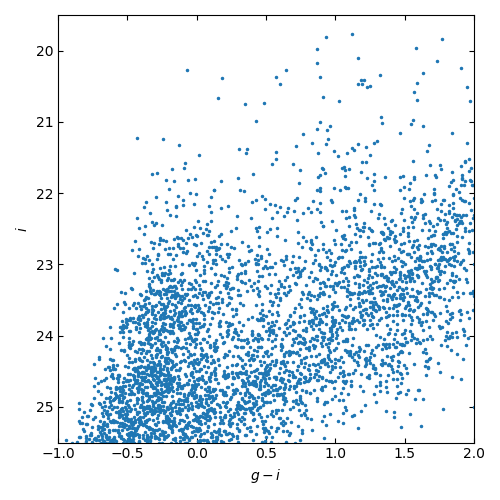

In [88]:
gi_color = ap_g['mag']-ap_i['mag']
imag = ap_i['mag']

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(gi_color, imag, '.', ms=3.0)
ax.set_xlim([-1.0, 2.0])
ax.set_ylim([25.5, 19.5])
ax.set_xlabel(r"$g-i$")
ax.set_ylabel(r"$i$")
# HolmIX = ((ap_g['x'] >= 1350) & (ap_g['x'] <= 1850) & (ap_g['y'] >= 750) & (ap_g['y'] <= 1250))
# ax.plot(gi_color[HolmIX], imag[HolmIX], '.', ms=4.0, color='red')
plt.tight_layout()